# Field Capacity Finder from the soil moisture

`[Run All] is mendatory`

## From the soil moisture data
***
### Data description
- data is being collected from the F70 field.
- soil moisture is in unit of %, **not cleaned**
- this script includes cleaning function
- this script designed to be used in daily basis.
- from the soil moisture monitoring website
- example data is 'Calc_def_test.csv'

- [soil moisture data](https://things.iot.ag.purdue.edu:8080/dashboard/dc56c5a0-ee3e-11ec-b72b-5dd76ca52a2b?publicId=a914a590-ecae-11ec-b72b-5dd76ca52a2b) input data for the script will be downloaded directly
> - soil moisture data is from Purdue AgIT server that collects the field data through LoRaWan network
> - the data should be downloaded from the 'Summary Data Table' tab
> 
- [weather data] input data for the script will be downloaded directly
> - weather data is from Purdue Mesonet server and using ACRE station data
> 
For downloading the data
  - Summary data table
  - from date1 to date2
  - in csv form
  - file name does not matter or add today's date at the end of the file name.
  

#### Version history
***
***
##### Version 1.1
- ver 1.1 branch made
- Shared with co-author Dr.Chandra
- Added Thingsboard API to the program
- deficit report export function to [./06_Deficit_results/] (2024-05-16)
- Added root zone estimation function (get_rootzone) (2024-05-19)
- [deficit_calc] Added crop, rootzone depth to the deficit output file (2024-05-19)
***
##### Version 2.0.2
###### _PENDING_
###### _DONE_
- [Variables] transmitters for each crop/managements is added (2024-06-24)
- [deficit_equation] Negative deficit (excessive moisture) is now excluded when calculating deficit (2024-06-25)
- [Root Directory] All the directory is cleaned and this script will be run in the root directory.
- [org_deficit] A new function added to create deficit log and graph in timeseries (2024-06-26)
- [org_deficit] The graph will show the recent seven days of the deficit (2024-06-27)

##### Version 2.0.3
###### _PENDING_
###### _DONE_
- [org_deficit] The graph unit changed into '%' (2024-06-28)
- [get_AWHCrz] Available Water Holding Capacity function added
- [org_deficit] The graph time range is 14 days (2024-06-28)
- [org_deficit] This function is `not` exporting graph anymore. Instead of the graphs, this function exports deficit reports for corn and soybean separately. But still exports integrated deficit results. (2024-06-28)

In [1]:
# Set up parameters for the simulation
import pandas as pd
import numpy as np

#*################ Global Parameters ################*#
# transmitter info
# should be changed in dictionary format later

CTRS = ['0554','0556','0557','0558','0629','0630']  # Corn Transmitter IDs
CITRS = ['0630','0557']
CFTRS = ['0556','0629']
CRTRS = ['0554','0558']

STRS = ['0111','0112','0113','0114','0115','0116']   # Soybean Transmitter IDs
SITRS = ['0112','0114']
SFTRS = ['0113','0116']
SRTRS = ['0111','0115']

'''
For the year 2024 Field season,
Planted:  Corn = 5/4, Soybean = 5/14
Emergence: Corn = 5/11, Soybean = 5/21
'''
CED = pd.Timestamp(2024, 5, 11) # Corn Emergence Date
SED = pd.Timestamp(2024, 5, 21) # Soybean Emergence Date

CRZMD = 24 # Corn Root Zone Max Depth (in)
CRZMDW = 7 # Week of Corn reaches Root Zone Max Depth (at the end of the week)
CRZI = 4 # Corn Root Zone Initial Depth (in)
CRZIW = 1 # Week of Corn reaches Root Zone Initial Depth

SRZMD = 24 # Soybean Root Zone Max Depth (in)
SRZMDW = 7 # Week of Soybean reaches Root Zone Max Depth (at the end of the week)
SRZI = 4 # Soybean Root Zone Initial Depth (in)
SRZIW = 1 # Week of Soybean reaches Root Zone Initial Depth



#*################ Mendatory Parameters ################*#

def get_periods(CED, SED):
    # get today's date as string
    from datetime import date
    today = date.today().strftime("%Y%m%d")

    # Get today's date as datetime
    TDY = pd.Timestamp.today()
    TWK = TDY.isocalendar().week
    print('Today is :', today, '// Week:', TWK)
    # Corn Week From Emergence
    Cweek = CED.isocalendar().week
    CWPE = TWK - Cweek  # Corn Week From Emergence
    print('Emergence week of corn :', Cweek, '//',CWPE, 'weeks from now')

    # Soybean Week From Emergence
    Sweek = SED.isocalendar().week
    SWPE = TWK-Sweek  # Soybean Week From Emergence
    print('Emergence week of soybean :', Sweek, '//',SWPE, 'weeks from now')

    return TDY, CWPE, SWPE


def cal_rz(TDY, CDE, SDE, CRZI, SRZI, CRZMDW, SRZMDW, CRZMD, SRZMD):
    # this program is using linear group root growth rate
    # get the root zone depth for corn and soybean
    # get the days from emergence until the index date of dlydata (CDFE/SDFE)
    CDFE = (TDY - CED).days
    SDFE = (TDY - SED).days
    
    # root zone growth rate of corn (CRZGR/SRZGR) = CDFE*(CRZMD-CRZI)/(CRZMDW-1)*7 (inch/day)
    CRZGR = (CRZMD-CRZI)/((CRZMDW-1)*7)
    SRZGR = (SRZMD-SRZI)/((SRZMDW-1)*7)
    print('Root zone Growth rate for Corn:     ', round(CRZGR,4), ('inch/day'))
    print('Root zone Growth rate for Soybean:  ', round(SRZGR,4), ('inch/day'))

    # calculate the root zone depth for corn and soybean
    # if (CRZ/SRZ) is lower than CRZI/SRZI, then CRZ/SRZ is CRZI/SRZI
    # if (CRZ/SRZ) is higher than CRZMD/SRZMD, then CRZ/SRZ is equal to CRZMD, SRZMD
    
    CRZ = CRZI + CDFE*CRZGR
    CRZ = CRZMD if CRZ > CRZMD else CRZ
    SRZ = SRZI + SDFE*SRZGR
    SRZ = SRZMD if SRZ > SRZMD else SRZ
    

    # if CRZ/SRZ is below CRZI/SRZI, then CRZ/SRZ is 0
    # this is because the date is before the emergence date
    CRZ = round(CRZ if CRZ > CRZI else 0,4)
    SRZ = round(SRZ if SRZ > SRZI else 0,4)

    print('Root Zone Depth for Corn:    ', CRZ, ('inch'))    
    print('Root Zone Depth for Soybean: ', SRZ, ('inch'))

    return CRZ, SRZ, CRZGR, SRZGR

TDY, CWPE, SWPE = get_periods(CED, SED)
CRZ, SRZ, CRZGR, SRZGR = cal_rz(TDY, CWPE, SWPE, CRZI, SRZI, CRZMDW, SRZMDW, CRZMD, SRZMD)


Today is : 20240630 // Week: 26
Emergence week of corn : 19 // 7 weeks from now
Emergence week of soybean : 21 // 5 weeks from now
Root zone Growth rate for Corn:      0.4762 inch/day
Root zone Growth rate for Soybean:   0.4762 inch/day
Root Zone Depth for Corn:     24 inch
Root Zone Depth for Soybean:  23.0476 inch


In [2]:
# // this part is download the data from the website for 2 month.
import requests
import sys
import os
import json
import pandas as pd
from pprint import pprint
import datetime
import pytz
# import config  # I don't know what is this config but this is meaningless DK 2024-06-24
from dateutil.relativedelta import relativedelta

deviceList = []

# ** set the configuration for the request                                                                                  **
config = {
 'username' : 'yang2309@purdue.edu', ### Insert your email address used by AgIT Thingsboard system
 'password': 'dsya2002',  ### Insert your AgIT thingsboard password
 'server' : 'https://things.iot.ag.purdue.edu:8080'
}

# ** defining the function to get the token for the request and setting the header for the request                          **
def getCustomerDevices(custID, textSearch=None):
    parameters = {        
        'pageSize': 1000,
        'page': 0,                
    }
    att_parms = {
        'keys': 'dev_eui'
    }
    if(textSearch):
        parameters.update({'textSearch': textSearch})
    responseList = requests.get(f"{config['server']}/api/customer/{custID}/devices", headers=TBheaders,params= parameters).json()
    #pprint(responseList)
    list = []
    for dev in responseList['data']:
        #pprint(dev)
        #print('------------------------------------------------------------------------------------------')
        #'id': {'entityType': 'DEVICE', 'id': 'd49153a0-c868-11eb-95d8-09d06ef6a9a5'},
        url = f"{config['server']}/api/plugins/telemetry/DEVICE/{dev['id']['id']}/values/attributes"
        deviceResp = requests.get(url, headers=TBheaders,params= att_parms).json()
        #print('------------------------------------------------------------------------------------------')
        list.append([dev['id']['id'],dev['name'],deviceResp[0]['value']])
    return list
        

def login(url, username, password):
    # Log into ThingsBoard
    return requests.post(f"{url}/api/auth/login", json={
        "username": username,
        "password": password
    }).json()['token']

def get_keys(device):
    return requests.get(f"{config['server']}/api/plugins/telemetry/DEVICE/{device}/keys/timeseries",
                 headers=TBheaders).json()
def get_data_chunk(url, token, device, key, start, stop, limit):
    #print([url, device, key, start, stop, limit])
    return requests.get(f"{url}/api/plugins/telemetry/DEVICE/{device}/values/timeseries",
             headers=TBheaders,
            params= {
                'keys': key,
                'startTs': start,
                'endTs': stop,
                'limit': limit,
                'agg': 'NONE'
            }).json()

def get_data(url, token, device, key, start, stop):
    global totalLength
    p = pd.DataFrame()
    
    # You have to request data backwards in time ...
    while start < stop:
        data = get_data_chunk(url, token, device[0], key, start, stop, 100000)
        #print(data)
        if key not in data:
            break;
        
        #print(f"{key}: Loaded {len(data[key])} points")
        t = pd.DataFrame.from_records(data[key])
        #t['Timestamp'] = t['ts']
        #pprint(t['ts'])
        t['ts'] = (pd.to_datetime(t['ts'],unit='ms'))        
        t.set_index('ts', inplace=True)
        
        t.rename(columns={'value': key}, inplace=True)
        p = p._append(t)

        # Update "new" stop time
        stop = data[key][-1]['ts'] - 1
    totalLength += len(p)
    #print(f"Total Length: {totalLength}")
    return p

def outputCSV(devices):
    global totalLength
    final_df = pd.DataFrame()
    for device in devices:
        #print(f"Downloading DEVICE: {device[0]} data");
        #print(device)
        p = pd.DataFrame()
        for key in keys:
            #print(f"info: Pulling {key}...");
            tempin = get_data(config['server'], token, device, key, startTS, endTS)            
            if(len(tempin)>0):                
                p = pd.concat([p,tempin], axis=1)
        p['Entity Name'] = device[1]
        p['dev_eui'] = device[2]
        p.reset_index(drop=False)
        #p_new_index = p.assign(**{'Timestamp': p.index})        
        if(len(p)):
            final_df = pd.concat([final_df,p])
        
    # Create Time Strings
    # Convert to nanoseconds for pandas.to_datetime
    start_timestamp_ns = startTS * 1000000
    end_timestamp_ns = endTS * 1000000
    
    # Convert timestamp to datetime object
    start_dt = pd.to_datetime(start_timestamp_ns, unit='ns')
    end_dt = pd.to_datetime(end_timestamp_ns, unit='ns')
    
    # Format datetime string as yyyy-mm-dd-HH-MM
    start_formatted_string = start_dt.strftime('%Y-%m-%d-%H-%M')
    end_formatted_string = end_dt.strftime('%Y-%m-%d-%H-%M')
    # Select variables to export
    df_order = ["Entity Name","data_soil_moisture1","data_soil_moisture2","data_soil_moisture3","data_soil_moisture4","data_tem1","data_tem2","data_tem3","data_tem4","data_tem5","data_tem6","data_tem7","dev_eui"]
    final_df = final_df.reindex(columns=df_order)
    final_df1 = final_df.sort_values(by='ts')
    
    # Get current time
    now = datetime.datetime.now()
    
    # Format time string (hours and minutes)
    formatted_time = now.strftime("%H-%M")
    final_df1.to_csv(f"./01_Raw_data/data-{end_formatted_string}.csv")
    print("File Export Done.")

def getDeviceCredentialsByDeviceId(deviceID = 0):
    url = config['server']+'/device/'+deviceID+'/credentials'
    resp = requests.get(url,headers=TBheaders)
    responseList = resp.json()
    #pprint(responseList)
    return responseList['credentialsID']

def getDeviceServerAttributes(deviceID = 0):
    if deviceID == 0:
        while(deviceID == 0):
            try:
                deviceID = input("Enter device ID: ")
            except:
                print("Invalid DeviceID")
    url = config['server']+'/plugins/telemetry/DEVICE/'+deviceID+'/values/attributes'
    #pprint(url)
    #pprint(TBheaders)
    xresp = requests.get(url,headers=TBheaders)
    #pprint(xresp)
    #pprint(resp.content())
    #print(xresp.text())
    responseList = xresp.json()
    #pprint(responseList)
    #return responseList['credentialsID']


# ** getting token for the request                                                                                         **
print("Server: ",config['server'])
token = login(config['server'], config['username'], config['password']);
print(f"Token: {token}")
TBheaders={ 'Accept': '*/*', 'X-Authorization': f"Bearer {token}" }



# Create a datetime object representing the local date and time
# Year, Month, Day, Hour, Minute
today_dt = datetime.datetime.now()
start = datetime.datetime.now()+ relativedelta(months=-2)

start_dt = datetime.datetime(start.year, start.month, start.day, 18, 0)
end_dt = datetime.datetime(today_dt.year, today_dt.month, today_dt.day, 6, 00)
print (start_dt, end_dt)

# Convert to a specific time zone (e.g., UTC)
start_tz_utc = pytz.timezone("UTC")
start_dt_utc = start_tz_utc.localize(start_dt)
end_tz_utc = pytz.timezone("UTC")
end_dt_utc = end_tz_utc.localize(end_dt)

# Extract the Unix timestamp
startTS = int(start_dt_utc.timestamp())*1000
endTS = int(end_dt_utc.timestamp())*1000

# Use for relative time frames
#startTS = int((datetime.now() - timedelta(days=30)  - datetime(1970, 1, 1)).total_seconds() * 1000) # 30 days ago
#endTS = int((datetime.datetime.utcnow() - datetime.datetime(1970, 1, 1)).total_seconds() * 1000) # now

# print(startTS, endTS)



# ** customer ID for the request                                                                                            **
# getCustomerDevices(custID, textSearch=None):
# 7576b020-ecae-11ec-b72b-5dd76ca52a2b = Cherkhauer Customer ID
# ABE-DRAGINO-GROPOINT-CHERKHAUER = Devices with names beginning with "ABE-DRAGINO-GROPOINT-CHERKHAUER"
devices = getCustomerDevices("7576b020-ecae-11ec-b72b-5dd76ca52a2b","ABE-DRAGINO-GROPOINT-CHERKHAUER-ACRE")
# pprint(devices)

totalLength = 0
# keys to retrieve
#keys = ["data_TempC_SHT","data_Hum_SHT"]
#keys = ["data_ambient_temperature","data_input1_frequency","data_input1_frequency_to_moisture","data_Input2_voltage","data_Input2_voltage_to_temp","data_light_intensity","data_relative_humidity"]
keys = ["data_soil_moisture1","data_soil_moisture2","data_soil_moisture3","data_soil_moisture4","data_tem1","data_tem2","data_tem3","data_tem4","data_tem5","data_tem6","data_tem7"]

outputCSV(devices)

Server:  https://things.iot.ag.purdue.edu:8080
Token: eyJhbGciOiJIUzUxMiJ9.eyJzdWIiOiJ5YW5nMjMwOUBwdXJkdWUuZWR1IiwidXNlcklkIjoiNjRlOWZjYjAtZjc0ZS0xMWVlLWIzYmMtN2ZlNjliZjhkNDExIiwic2NvcGVzIjpbIkNVU1RPTUVSX1VTRVIiXSwic2Vzc2lvbklkIjoiMGI3N2RjNmYtMWUxOS00OTYwLTk2MTktMzJhMTg5YTM0ZTI2IiwiaXNzIjoidGhpbmdzYm9hcmQuaW8iLCJpYXQiOjE3MTk3NjkwNDYsImV4cCI6MTcxOTc3ODA0NiwiZmlyc3ROYW1lIjoiRG9uZ3Nlb2siLCJsYXN0TmFtZSI6IllhbmciLCJlbmFibGVkIjp0cnVlLCJpc1B1YmxpYyI6ZmFsc2UsInRlbmFudElkIjoiYWFjNjU1YTAtYWM2Mi0xMWVjLWFiYzgtMWYxYzA5NTgwZTY3IiwiY3VzdG9tZXJJZCI6Ijc1NzZiMDIwLWVjYWUtMTFlYy1iNzJiLTVkZDc2Y2E1MmEyYiJ9.dyO11lEGwd-H9ixdPm9BQkHFOVasKz0Xjx0rwhXhP6L9WLMybVUE4iICFuUDhsCOaur7FrXmRTmg4BMENQutrQ
2024-04-30 18:00:00 2024-06-30 06:00:00
File Export Done.


## Initial data reading process
***
### readraw_data Function

The `readraw_data` function is used to read raw data from a CSV file and parse it into a pandas DataFrame.

#### Parameters

- `destination`: The path where the output file will be saved.
- `filename`: The name of the CSV file to be read.
- `foutname`: The name of the output file.
- `st_date`: The start date for the data to be read.
- `ed_date`: The end date for the data to be read.

#### Returns

- `raw_data`: A pandas DataFrame that contains the data read from the CSV file.

#### Functionality

The function works by using the pandas `read_csv` function to read the CSV file. It specifies the delimiter as ';' and parses the 'Timestamp' column as dates. It also specifies the data types for the soil moisture columns to be float64.

The function then returns the DataFrame.
***
### station_data_clean Function

The `station_data_clean` function is used to clean the data for a specific station.

#### Parameters

- `raw_data`: A pandas DataFrame that contains the raw data to be cleaned.
- `station`: An integer that represents the station ID.

#### Returns

- `station_data`: A pandas DataFrame that contains the cleaned data for the specified station.

#### Functionality

The function works by filtering the raw data for the specified station. It then performs any necessary cleaning operations, such as removing missing values, outliers, or incorrect data.

The function then returns the cleaned data for the specified station.

Please note that the actual code for the `station_data_clean` function is not provided, so the parameters and functionality are assumed based on typical usage. If you provide the actual code of the `station_data_clean` function, I can give a more accurate explanation.

In [3]:
# -*- coding: utf-8 -*-
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt
import statistics as stats
import os


today = dt.date.today()
# today = datetime(2009, 7, 6, 0, 0)
strtoday = today.strftime("%Y%m%d")
print ('Today is :: ',today)



def readraw_data(destination, filename, foutname, st_date, ed_date):
    print ('File name is ::',filename)
    # open the file
    # TODO delimeter should be changed to ',' for the csv file.  ts <=> Timestamp.  delimiter=',' <=> delimiter=';'
    raw_data = pd.read_csv(filename,delimiter=',', parse_dates=['ts'],
                          dtype={'data_soil_moisture1':np.float64,
                                 'data_soil_moisture2':np.float64,
                                 'data_soil_moisture3':np.float64,
                                 'data_soil_moisture4':np.float64},
                          na_values=['Invalid data']
                          )
    raw_columns = raw_data.columns.tolist()
    # raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'])
    # drop the temperature data from the list
    for i in range(len(raw_columns)):
        if 'tem' in raw_columns[i] or 'dev' in raw_columns[i]:
            raw_data = raw_data.drop(columns=raw_columns[i])
            
    raw_data.set_index(['ts'])
    print(raw_data.info())
    
    # change the name of the Entity Name column
    raw_data['Entity Name'] = raw_data['Entity Name'].str.replace('ABE-DRAGINO-GROPOINT-CHERKHAUER-ACRE-','')
    stationlist = sorted(raw_data['Entity Name'].unique())
        
    
    # after checking the null values, filter the data
    clean_df = pd.DataFrame(columns = ['Station','Layer1', 'Layer2', 'Layer3', 'Layer4'])
    for station in stationlist:
        # clean the data according to the cleaning procedure
        sample_df = station_data_clean(destination, raw_data, station)
        
        clean_df = pd.concat([clean_df,sample_df])
        
    clean_df.to_csv(destination+foutname,index=True)
    
    # convert headers only with numbers
    raw_columns = raw_data.columns.tolist()
    
    # group the dataframe and turn them into another dataframe with 'Entity Name' as columns.
    # this step should be done by layer.
    

    return raw_data, raw_columns, clean_df, stationlist, raw_columns



# ********************************************************************************************************************
# * this is the function that goes into readraw_data function.                                                       *
# ********************************************************************************************************************
def station_data_clean(destination, raw_data, station):
    global start_date, end_date
    '''
    This is cleaning for station data

    Parameters
    ----------
    raw_data : dataframe
        dataframe of the raw_data, 'raw_data' in this script
    station : string
        this is number of station. 4 digit number filled with zero from left

    Returns
    -------
    sample_df : dataframe
        this cleaned data after process

    '''
    sample_df = raw_data[raw_data['Entity Name']==station]
    sample_df = sample_df.drop(['Entity Name'], axis=1)
    sample_df = sample_df.set_index('ts')
    sample_df = sample_df.set_axis(['Layer1', 'Layer2', 'Layer3', 'Layer4'], axis=1)
    
    # clean the data by time of interest
    # datetime range should start by 18:00 // end by 6:00 for better analysis for everyday
    start_date = dt.datetime(st_date[0], st_date[1], st_date[2], 0, 0, 0)
    end_date = dt.datetime(ed_date[0], ed_date[1], ed_date[2], 6, 0, 0)
    sample_df = sample_df[(sample_df.index > start_date) & (sample_df.index < end_date)]
    
    # according to the number of the data length,
    # if it is more than 1, the dataframe will be made
    # if it is 0, below process will be skipped
    totnum = len(sample_df)
    if totnum > 0:    
        print ('\n\n')
        txt = ' raw_data info for station '+station+' '
        print(txt.center(60,'='),end='\n')
        
        # if value is null value from beginning
        print(' NaN values info '.center(60,':'))
        na_df = sample_df[sample_df.isna().any(axis=1)]
        sample_df = sample_df.dropna()
        print('NaN values are ::',len(na_df),'out of',totnum,'\nerror rate:',round(len(na_df)/totnum*100,2),'%',end='\n\n')
        
        # if value is out of range
        sample_df[(sample_df>=100.0) | (sample_df<=0.0)] = np.nan
        outrange_df = sample_df[sample_df.isna().any(axis=1)]
        sample_df = sample_df.dropna()
        print('Out of range values are ::',len(outrange_df),'out of',totnum,'\nerror rate:',round(len(outrange_df)/totnum*100,2),'%',end='\n\n')
        
        print(' Data Describe '.center(60,':'),end='\n\n')
        print(sample_df.dtypes, end='\n\n')
        print(sample_df.describe())
        
        # resampling in 30 min frequency
        sample_df = sample_df.resample('30min').mean()
        
        # make boxplot per layer
        boxplot = sample_df.boxplot(column=['Layer1', 'Layer2', 'Layer3'],figsize=(8,4), ylabel='Soil Moisture (%)')
        plt.title(int(station))
        plt.savefig(destination+'/03_Soil_moisture_graphs/'+strtoday+'_'+station+'.png',dpi=600)
        plt.show()
        
        # add station code back
        sample_df['Station'] = int(station)
    
        print('='*60)
        
    else:
        txt = station+' '
        print(txt.center(60,'='),end='\n\n')
    '''
    # save station dataframe as csv file == turned off for cal_deficit
    try:
        sample_df.to_csv(destination+'station_data/'+station+'_cleaned.csv',sep=',')
        print('Transmitter data exported.')
    except:
        print('Transmitter data export failed.')
    '''
    
    return sample_df

Today is ::  2024-06-30


## Rainfinder Function

The `rainfinder` function is used to identify significant rain events in a given dataset. The function is designed to analyze weather data and detect periods of rainfall based on certain conditions or thresholds.

### Parameters

- `data`: A pandas DataFrame that contains the weather data to be analyzed. The DataFrame should be indexed by 'Timestamp and Station'.
- `station`: An integer that represents the station ID.
- `header`: A list that contains the headers of the data.
- `threshold_moist`: An integer that represents the threshold of soil moisture difference to decide if it was a significant rain event or not.
- `raintimestep`: An integer that represents the number of time steps to consider for the rolling window.

### Returns

- `bumplist2`: A list of lists. Each inner list represents a date (in the format [year, month, day]) when a significant rain event (or "bump") was detected.

### Functionality

The function works by first filtering the data for the specified station and removing any missing values. It then calculates the difference in soil moisture between each time step and filters out the time steps where the difference is greater than the specified threshold.

The function then uses a rolling window to find the minimum and maximum soil moisture values within each window. It calculates the gap between the min and max values and filters out the time steps where the gap is greater than the threshold.

The function then organizes the dates of these significant rain events, removes duplicates, and sorts the list. The sorted list of dates is returned.

The function uses pandas for data manipulation and filtering.

In [4]:
def rainfinder(data, station, header, threshold_moist, raintimestep):
    """
    

    Parameters
    ----------
    data : dataframe
        organized dataframe / index is 'Timestamp and Station'
    stationlist : list
        list of the stations
    header : list
        header of the data
    threshold_moist : int
        threshold of soil moisture difference to decide it was huge rain event or not
        
    Returns
    -------
    data_dur_all : list of dataframe
        this is dataframes with time range of interest
        dataframe order is accordance with order of station list (stationlist)

    """
    text = station +' :: '+target+'  Rainfinder'
    print (text.center(60,':'))

    data_dur = data[data['Station']==int(station)]
    data_dur = data_dur.dropna()
    
        
    # make a rolling window column from interpolation
    # data_dur[target] = data_dur[target].interpolate()
    print (station,'|','LEN =', len(data_dur))
    
    # find differene between each time step
    temp = data_dur[target].diff()
    filtered_temp = temp.to_frame(name=target).query('{target} > @threshold_moist'.format(target = target))
    
    # find biggest difference within 3 hours (6 timesteps) == bump
    data_dur['min_'+target] = data_dur[target].rolling(window=raintimestep).min()
    data_dur['max_'+target] = data_dur[target].rolling(window=raintimestep).max()
    data_dur['gap_'+target] = data_dur['max_'+target] - data_dur['min_'+target]
    filtered_temp = data_dur.query('gap_{target} > @threshold_moist'.format(target = target))
    #print (filtered_temp)

    # organizing the date of bump
    bumplist = filtered_temp.index.to_list()        
    for i in range(len(bumplist)):
        # make a list of date with the bump in the form of [year, month, day]
        bumplist[i] = [bumplist[i].year, bumplist[i].month, bumplist[i].day]
    # remove duplicates in bumplist
    bumplist2 = list(set(map(tuple, bumplist)))
    # sort the list and convert tuples into list
    bumplist2 = sorted(bumplist2)
    for i in range(len(bumplist2)):
        bumplist2[i] = list(bumplist2[i])

    print ('Searched ', len(bumplist2), 'days with bump events')
    print (bumplist2)

    return bumplist2



## FCfinder Function

The `FCfinder` function is used to find the field capacity of soil after a given number of days from a specified start date. Field capacity is the amount of soil moisture or water content held in the soil after excess water has drained away and the rate of downward movement has decreased. This capacity is reached within 2–3 days after rain or irrigation in typical soil conditions.

### Parameters

- `data`: A pandas DataFrame that contains the data to be analyzed. The DataFrame should be indexed by 'Timestamp and Station'.
- `station`: An integer that represents the station ID.
- `header`: A list that contains the headers of the data.
- `start_date`: A list that contains the start date of the data search in the format [year, month, day].
- `search_days`: An integer that represents the number of days to search for field capacity.
- `search_range`: An integer that represents the range (in hours) for moving field capacity.
- `search_slope`: A float that represents the slope for searching.
- `threshold_hour`: An integer that represents the threshold hours that remains flat soil moisture behavior to confirm it is a field capacity point.

### Returns

- `data_dur_all`: A list of pandas DataFrames. Each DataFrame contains a time range of interest. The order of the DataFrames corresponds to the order of the station list.

### Functionality

The function works by iterating over a specified number of days from the start date. For each day, it identifies a time range around midnight and checks if the standard deviation of the soil moisture within this time range is less than the specified slope. If it is, the function considers this as a constant moisture behavior and records the date and the mean soil moisture value. The function then plots the soil moisture and the field capacity points, saves the plot as a PNG file, and writes the field capacity records to a CSV file.

The function uses a rolling window to smooth the soil moisture data and uses the standard deviation to identify constant moisture behavior. It also uses matplotlib for plotting and os for file operations.

In [5]:
def FCfinder(data, station, header, start_date, search_days, search_range, search_slope, threshold_hour):
    global searched, precip_search1, precip_search2, precip_delta, precip_max

    # print ('Station',station, 'Date',start_date)
    # important == rl means rolling window. if you don't want, remove it.
    search_target = target
    # search_target = 'rl_'+target
    layer_index = int(target[-1])-1

    data_dur_all = [] # this is test list to save all the data_dur searched
    data_dur = data[data['Station']==int(station)]
    
        
    # make a rolling window column from interpolation
    data_dur['Layer1'] = data_dur['Layer1'].interpolate()
    data_dur['Layer2'] = data_dur['Layer2'].interpolate()
    data_dur['Layer3'] = data_dur['Layer3'].interpolate()
    data_dur['Layer4'] = data_dur['Layer4'].interpolate()
    # data_dur['rl_'+target] = data_dur[target].rolling(window=3).mean()
    

    '''
    From here, we need to find out point where soil moisture value is consistent for 2 hours (threshold_hour)
    And consistent variation for this hour is < 1% (search_slope)
    Searching range will be +- 4hrs from midnight (search_range)
    '''
    # set the database only for the search_target
    target_data = data_dur[search_target]
    
    # find 00:00 hour of everyday within TOI (7 days)
    dayrange = search_days
    
    # this list is for the searched fc dates
    searched_list = []
    
    # searching field capacity (daily)
    for days in range(1,dayrange+1):
        # Going to find the field capacity after given days from the start_date
        st_datetime = dt.datetime(start_date[0], start_date[1], start_date[2], 6, 0, 0)

        # stamp2 is 4 hours before the midnight of the stamp1
        # stamp3 is 4 hours after the midnight of the stamp2
        # add 'days' to search every daily step
        stamp1 = st_datetime + dt.timedelta(days=days)
        stamp1 = stamp1.replace(hour=0, minute=0, second=0)
        
        # step 1. select the time range of interest
        # once you find the time, you will search there is constant soil moisture behavior or not
        # set the searching time
        stamp2, stamp3 = stamp1 - dt.timedelta(hours=search_range), stamp1 + dt.timedelta(hours=search_range)
        # stamp3 = stamp1 + dt.timedelta(hours=search_range)
        
        # step 2. set the searching range
        searched = target_data[(target_data.index > stamp2) & (target_data.index < stamp3)]
        # searched = data_search
            
        try:
            # if standard deviation does not exceeds 'search_slope',
            # this will be regarded as constant moisture behavior
            if stats.stdev(searched) < search_slope:
                searched_list.append([stamp1, stats.mean(searched)])
                FC_searched = True
            else:
                FC_searched = False # if there is no constant behavior, FC_searched will be False == no field capacity
        except:
            FC_searched = False # this case is no data in the range, so FC_searched will be False == no field capacity
        
        if FC_searched == True:
            print ('Field Capacity is found for',str(start_date[0])+'-'+str(start_date[1])+'-'+str(start_date[2]),':',searched_list[0][0].strftime('%Y-%m-%d'),round(searched_list[0][1],3))

        
            # list of searched field capacity this value will be only one pair.
            searched_dates = [i[0] for i in searched_list]
            searched_values = [i[1] for i in searched_list]
            
            # if field capacity is found, draw graph
            if len(searched_dates) > 0:
                # draw overlaying graph for the soil moisture and field capacity
                # soil moisture is blue line and field capacity is red dot            
                df_subset = data_dur[(data_dur.index < stamp1+dt.timedelta(days=1)) & (data_dur.index > st_datetime)]
                # print(df_subset)

                fig, ax = plt.subplots(figsize=(12, 5))
                # ax = data_dur.plot(y=target, label = 'Observed values', figsize=(15,5))
                ax = plt.plot(df_subset.index, df_subset[target], label = 'Observed values')

                # ax.set_xlim(stamp2, stamp3)
                plt.scatter(x=searched_dates, y=searched_values, label = 'Moving FC points', marker='s', c='r', s=100)
                plt.legend()
                plt.gcf().autofmt_xdate()
                plt.xlabel('Date')
                plt.ylabel('Soil Moisture (%)')
                plt.title('Field Capacity for '+str(station)+' after '+st_datetime.strftime('%Y-%m-%d')+' precipitation')

                # save graph for the soil moisture and field capacity
                graph_dest = os.getcwd()+'/05_fc_graphs/'+st_datetime.strftime('%Y-%m-%d')
                if not os.path.exists(graph_dest):
                    os.makedirs(graph_dest)
                plt.savefig(graph_dest+'/'+str(station)+'_'+stamp1.strftime('%Y-%m-%d')+'.png',dpi=600)
                # plt.show()
                print('Graph is saved.')
            
            # save field capacity records in csv form
            data_dur_all.append(data_dur)
            
            
            # save field capacity records in csv form
            # print('searched_list ::',searched_list)
            with  open(os.getcwd()+'/04_fc_results/'+strtoday+'_fc_record.csv', 'a+') as f:
                for item in searched_list:
                    strdate = item[0].strftime('%Y-%m-%d')
                    sm_list = data_dur[data_dur.index==item[0]].iloc[0,:].values.tolist()[1:]
                    sm_list = [str(round(i,3)) for i in sm_list]
                    sm_list_str = ','.join(map(str, sm_list))
                    f.write(str(station)+','+strdate+','+sm_list_str+'\n')
            
            break


## update_fc function
### About
***
This function helps to update the field capacity file in the root directory `./00_Current_FieldCapacity.csv`.\
This file contains only recent data of the field capacity

In [6]:
def update_fc():
    filename = os.getcwd()+'/04_fc_results/'+strtoday+'_fc_record.csv'
    # open the daily fc file & read
    raw_data = pd.read_csv(filename,delimiter=',', parse_dates=['Date'],
                          dtype={'data_soil_moisture1':np.float64,
                                 'data_soil_moisture2':np.float64,
                                 'data_soil_moisture3':np.float64,
                                 'data_soil_moisture4':np.float64},
                          na_values=['Invalid data']
                          )
    raw_data = raw_data.dropna()    # drop the rows if there is NaN values
    raw_data.drop_duplicates(inplace=True)  # remove duplicate rows
    raw_data.to_csv(filename,index=False)   # export the data to csv file    
    raw_data = raw_data.sort_values(by=['Station','Date'])  # sort the data by station and date
    last_date = raw_data.groupby('Station').tail(1) # get the last date of the data

    # open the 00_Current_FC.csv file & read
    fc_data = pd.read_csv(os.getcwd()+'/00_Current_FieldCapacity.csv',delimiter=',', parse_dates=['Date'],
                          dtype={'data_soil_moisture1':np.float64,
                                 'data_soil_moisture2':np.float64,
                                 'data_soil_moisture3':np.float64,
                                 'data_soil_moisture4':np.float64},
                          na_values=['Invalid data']
                          )
    fc_data = pd.concat([fc_data,raw_data]) # concat fc_data and raw_data
    fc_data = fc_data.drop_duplicates() # remove duplicate rows
    fc_data = fc_data.sort_values(by=['Station','Date']) # sort the data by station and date
    fc_data = fc_data.groupby('Station').tail(1) # get the last date of the data and update the data
    fc_data.to_csv(os.getcwd()+'/00_Current_FieldCapacity.csv',index=False) # export the data to csv file
    

## Defecit Calc function
### About
***


The provided Python code defines two functions: `deficit_calc` and `deficit_equation`.

1. `deficit_calc(thedate, rootdpth)`: This function calculates the soil moisture deficit for a given date and root depth across multiple stations. 

   - **Parameters**: 
     - `thedate`: The date of interest.
     - `rootdpth`: The root depth.

   - **Process**: 
     - It loops over a list of stations (`stationlist`), which is not defined in the provided code.
     - For each station, it filters the `raw_data` DataFrame (also not defined in the provided code) to get data for that station and drops any rows with missing values.
     - It then tries to find the soil moisture value (`sm_val`) for the date of interest and the field capacity value (`fc_val`) for the station from a CSV file.
     - It calls the `deficit_equation` function to calculate the deficit and prints the result.
     - If there's no data for a station, it prints a message indicating this.

2. `deficit_equation(ts, station, rootdpth, sm_val, fc_val)`: This function calculates the soil moisture deficit for a given station on a specific date. 

   - **Parameters**: 
     - `ts`: The date.
     - `station`: The station.
     - `rootdpth`: The root depth.
     - `sm_val`: The soil moisture value.
     - `fc_val`: The field capacity value.

   - **Process**: 
     - It calculates the deficit based on the root depth and the difference between the field capacity and the soil moisture value for different soil layers. The calculation is done in centimeters (hence the multiplication by 0.01).
     - It rounds the deficit to two decimal places and returns it.

The commented-out code at the top appears to be an earlier version of the deficit calculation, which is now performed by the `deficit_equation` function.

In [7]:
'''
#! Dr.Bowling's equation for the defecit calculation
df2.loc[df2['soil_moisture1'] < fcdf.fc1, 'd1']=fcdf.fc1-df2['soil_moisture1']
df2.loc[df2['soil_moisture2'] < fcdf.fc2, 'd2']=fcdf.fc2-df2['soil_moisture2']
df2.loc[df2['soil_moisture3'] < fcdf.fc3, 'd3']=fcdf.fc3-df2['soil_moisture3']
df2.loc[df2['soil_moisture4'] < fcdf.fc4, 'd4']=fcdf.fc4-df2['soil_moisture4']

if root < 6:
    df2['Deficit'] = (df2['d1'])*root
elif root < 12:
    df2['Deficit'] = (df2['d1'])*6 + (df2['d2'])*(root-6)
elif root < 18:
    df2['Deficit'] = (df2['d1'])*6 + (df2['d2'])*6 + (df2['d3'])*(root-12)
else:
    df2['Deficit'] = (df2['d1'])*6 + (df2['d2'])*6 + (df2['d3'])*6 + (df2['d4'])*(root-18)

'''
def deficit_calc ():
    
    # read the soil moisture values from raw_data close to the midnight
    # date of the interest is ts
    # ts = dt.date(2023, 7, 12) # for testing
    ts = dt.date.today()
    ts = pd.to_datetime(ts)
    print('Date of the interest is ',ts)

    # open the file
    f = open(os.getcwd()+'/06_Deficit_results/'+strtoday+'_deficit_report.csv','w') # create the file
    f.write('Date,Station,Crop,Rootdpth(inch),Deficit(inch),sm_val1(%),sm_val2(%),sm_val3(%),sm_val4(%),fc_date,fc_val1(%),fc_val2(%),fc_val3(%),fc_val4(%)\n') # write the header

    for station in stationlist:

        # fliter the raw_data by station and drop the NaN values
        sample_df = raw_data[raw_data['Entity Name']==station].dropna()
        sample_df.set_index('ts', inplace=True)
        
        try:
            # get the midnight value of the date of the interest
            iloc_idx = sample_df.index.get_indexer([ts], method='nearest')  # returns absolute index into df e.g. array([5])
            loc_idx = sample_df.index[iloc_idx]                             # if you want named index
            sm_val = sample_df.iloc[iloc_idx]
            sm_val = sample_df.loc[loc_idx]                                 # as above so below...    
            
            # convert my_val to list
            sm_val = sm_val.values.tolist()[0]
            print('sm_val',sm_val)

            # get the field capacity value from the 00_Current_FieldCapacity.csv
            fcdf = pd.read_csv(os.getcwd()+'/00_Current_FieldCapacity.csv')
            fc_val = fcdf[fcdf['Station']==int(station)].values.tolist()[0]
            print('fc_val',fc_val)
            
            # calculate the deficit
            crop, rootdpth, deficit = deficit_equation(ts,station, sm_val, fc_val)
            
            print('>>> Deficit for',ts,'at',int(station),'is',deficit,'& FC date is:',fc_val[1],end='\n\n')
            f.write(str(ts)+','+str(station)+','+crop+','+str(rootdpth)+','+str(deficit)+','+','.join(str(x) for x in sm_val[1:])+','+str(fc_val[1])+','+','.join(str(x) for x in fc_val[2:])+'\n')

        
        except:
            txt = 'No data for  '+station
            print(txt.center(60,'='),end='\n\n')
        
    f.close() # close the deficit report file 



def deficit_equation(ts,station, sm_val, fc_val):
    # rootdpth comes from cal_rz function and CTRS/STRS
    # negative values should be removed when considering the deficit
    if station in CTRS:
        rootdpth = CRZ
        crop = 'Corn'
    elif station in STRS:
        rootdpth = SRZ
        crop = 'Soybean'
    else:
        ('Station is not in the list. Check please.')
    '''
    # this is old version and counting negative values as deficit
    if rootdpth < 6:
        deficit = ((fc_val[2]-sm_val[1])*rootdpth)*0.01
    elif rootdpth < 12:
        deficit = ((fc_val[2]-sm_val[1])*6 + (fc_val[3]-sm_val[2])*(rootdpth-6))*0.01
    elif rootdpth < 18:
        deficit = ((fc_val[2]-sm_val[1])*6 + (fc_val[3]-sm_val[2])*6 + (fc_val[4]-sm_val[3])*(rootdpth-12))*0.01
    else:
        deficit = ((fc_val[2]-sm_val[1])*6 + (fc_val[3]-sm_val[2])*6 + (fc_val[4]-sm_val[3])*6 + (fc_val[5]-sm_val[4])*(rootdpth-18))*0.01
    '''
    # find the rootzone depth and how many layers should be considered
    # divide by 6 and get the quotient first. if quotient is 0, then only layer 1 is considered. if 1, layer 1 and 2 are considered. if 2, layer 1, 2, and 3 are considered. if 3, all layers are considered, regardless of the remainder.
    layercount = int(rootdpth//6)
    deficit = 0
    # loop for the layercount
    imax = layercount+2 if layercount < 3 else 5

    for i in range(1,imax):
        layer_deficit = (fc_val[i+1] - sm_val[i])*0.01
        layer_deficit = 0 if layer_deficit < 0 else layer_deficit
        # find the rootdpth in the layer
        rootdpthinlayer = 6 if 6*i < rootdpth else rootdpth - 6*(i-1)
        layer_deficit = layer_deficit * rootdpthinlayer

        deficit += layer_deficit
        print('Layer',i,'/'+str(layercount),rootdpthinlayer,'(inch). ','Deficit:',layer_deficit)

    deficit = round(deficit,2)

    print (ts, station, rootdpth, sm_val, fc_val, deficit)
    return crop, rootdpth, deficit


## Additional Functions


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

def org_deficit():
    # this script is for organizing the deficit report
    # get the deficit report files in the 06_Deficit_results folder
    report_list = os.listdir('./06_Deficit_results')
    # leave file names endswith csv
    report_list = [x for x in report_list if x.endswith('.csv')]
    report_list.remove('deficit_report.csv')
    report_list.remove('Corn_deficit_report.csv')
    report_list.remove('Soybean_deficit_report.csv')
    
    
    # using the for loop, read all the files in the report_list and merge them into one dataframe
    deficit_df = 0
    deficit_df = pd.DataFrame()
    for report in report_list:
        temp = pd.read_csv('./06_Deficit_results/'+report)
        deficit_df = pd.concat([deficit_df,temp])
    # sort the dataframe by date and station
    deficit_df = deficit_df.sort_values(by=['Date','Station'])
    # change the date format to yyyy-mm-dd
    deficit_df['Date'] = pd.to_datetime(deficit_df['Date']).dt.strftime('%Y-%m-%d')

    # save the dataframe as csv file
    deficit_df.to_csv('./06_Deficit_results/deficit_report.csv',encoding="utf-16",index=False)

    # filter dataframe if crop is corn
    corn_df = deficit_df[deficit_df['Crop']=='Corn']
    soybean_df = deficit_df[deficit_df['Crop']=='Soybean']
    # draw a graph of all the station's decifit(inch) by date in one graph
    for cropdf in [soybean_df,corn_df]:
        # find out the crop name
        axtitle = cropdf['Crop'].unique()[0]
        # get only previous 7 days data from the cropdf
        cropdf = cropdf[cropdf['Date'] > (dt.datetime.now() - dt.timedelta(days=14)).strftime('%Y-%m-%d')]
        # get the AWHCrz for the cropdf
        cropdf = get_AWHCrz(cropdf)
        cropdf['Deficit(%)'] = cropdf['Deficit(inch)']/cropdf['AWHC (inch)']*100
        cropdf.to_csv('./06_Deficit_results/'+axtitle+'_deficit_report.csv',encoding="utf-16",index=False)
        
        '''
        function not in use anymore
        fig, ax = plt.subplots(figsize=(12, 8))
        
        for station in cropdf['Station'].unique():
            temp = cropdf[cropdf['Station']==station]
            ax.plot(temp['Date'],temp['Deficit(%)'],label=station)
            # change x axis format as yyyy-mm-dd
            # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            # label near the highest y-value of each lines
            ymax = temp['Deficit(%)'].max()
            xmax = temp[temp['Deficit(%)']==ymax]['Date'].values[0]
            ax.text(xmax, ymax, station, fontsize=9)
        
        ax.set_title(axtitle+' Deficit (%)')
        ax.set_xlabel('Date')
        ax.set_ylabel('Deficit(%)')
        ax.legend()
        # plt.xticks(rotation=45)
        # save the figure
        plt.savefig('./00_OBS_'+axtitle+'_deficit_graph.png',dpi=400)
        # plt.show()
        # initialize the figure
        plt.clf()
        '''
    return deficit_df





def get_AWHCrz(dlydata):
    # ! this function is by Dr. Chandra
    # calculate the available water holding capacity of the root zone for corn and soybean
    Soltable = pd.DataFrame({
        'Layer': np.arange(0,8),
        'From': [0,0,6,12,18,24,48,48],
        'To': [0,6,12,18,24,48,48,48],
        'Thickness': [0,6,6,6,6,0,0,0],
        'AWHC': [0,0.23,0.23,0.21,0.2,0,0,0]})


    Soltable['AWHCj']=Soltable['Thickness']*Soltable['AWHC']
    Soltable['AWHCj_cum']=Soltable['AWHCj'].cumsum()
    Soltable1=Soltable[['To','AWHCj_cum']]

    # nest function for the AWHCrz calculation
    def AWHCrz_func(rz):
        if rz in Soltable1['To'].values:
            i = Soltable1.index[Soltable1['To'] == rz][0]
            dfx = Soltable1.iloc[i:i+2]
        else:
            Soltable1["To"] > rz
            v = Soltable1["To"] > rz 
            i = v[v].index[0]   
            dfx = Soltable1.iloc[i-1:i+1]

        AWHCrz= ((rz-dfx.iloc[0][0])/(dfx.iloc[1][0]-dfx.iloc[0][0]))* (dfx.iloc[1][1]-dfx.iloc[0][1])+dfx.iloc[0][1]        

        return AWHCrz
    
    dlydata['AWHC (inch)'] = dlydata.apply(lambda x: AWHCrz_func(x['Rootdpth(inch)']), axis=1)

    return dlydata

# Below is implementation Block
- **Station List**: This line prints the list of stations to the console.

- **Target Layer**: This is the target layer for the analysis. The variable `target` is set to 'Layer2'.

- **Rainfinder Variables**: The variables `threshold_moist` and `raintimestep` are set for the `rainfinder` function. `threshold_moist` is the soil moisture difference threshold to decide if a significant rain event has occurred. `raintimestep` is the time step for rain detection, where 1 represents half an hour and 12 represents 6 hours.

- **FCfinder Variables**: The variables `search_days`, `search_range`, `search_slope`, and `threshold_hour` are set for the `FCfinder` function. `search_days` is the number of days to search for field capacity. `search_range` is the number of hours to search around a given timestamp. `search_slope` is the standard deviation threshold for soil moisture behavior. `threshold_hour` is the number of hours with consistent soil moisture behavior.

- **File Creation**: A new CSV file is created in the `fc_results` directory to store the daily field capacity results. The file is named with the current date (`strtoday`). The first line of the file is a header line with the column names.

- **Main Loop**: This is the main loop of the program. For each station in the `stationlist`, it prints the station ID and target layer. It then calls the `rainfinder` function to get a list of dates (`bumplist`) where significant rain events occurred. For each of these dates, it calls the `FCfinder` function to estimate the field capacity.

File name is :: c:\Users\dsyan\Documents\Github\SoilMoisture_analysis/01_Raw_data/data-2024-06-30-06-00.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25550 entries, 0 to 25549
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ts                   25550 non-null  datetime64[ns]
 1   Entity Name          25550 non-null  object        
 2   data_soil_moisture1  23571 non-null  float64       
 3   data_soil_moisture2  23571 non-null  float64       
 4   data_soil_moisture3  23571 non-null  float64       
 5   data_soil_moisture4  23571 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.2+ MB
None



============== raw_data info for station 0111 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 824 out of 1637 
error rate: 50.34 %

Out of range values are :: 0 out of 1637 
error rate: 0.0 %

::::::::::

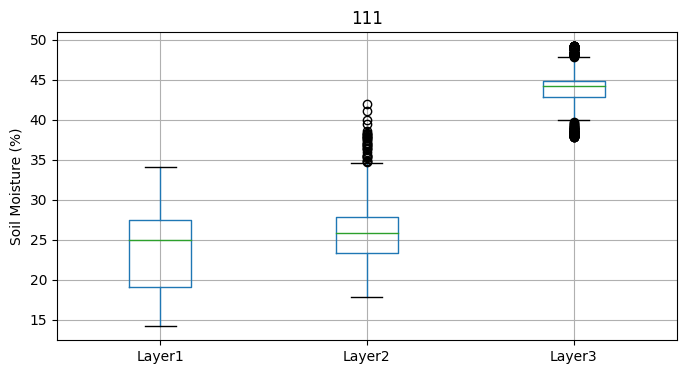




============== raw_data info for station 0112 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 75 out of 2776 
error rate: 2.7 %

Out of range values are :: 0 out of 2776 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  2701.000000  2701.000000  2701.000000  2701.000000
mean     24.952203    35.620696    45.332506    49.311329
std       4.937864     5.669854     4.363634     3.197892
min      15.500000    20.300000    32.700000    36.500000
25%      21.500000    32.700000    43.700000    48.500000
50%      24.600000    34.500000    46.900000    50.000000
75%      27.800000    40.700000    48.100000    50.800000
max      54.800000    53.300000    52.500000    57.200000


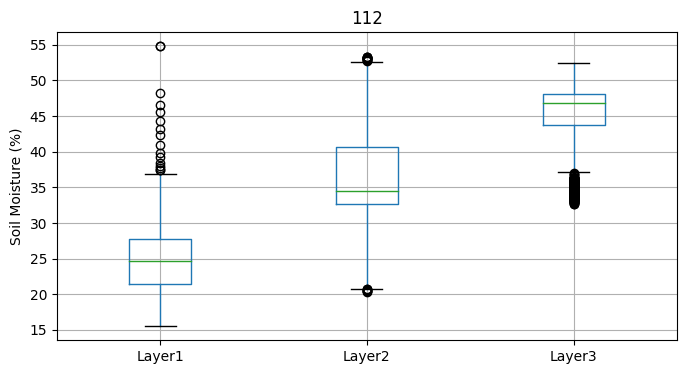




============== raw_data info for station 0113 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 60 out of 1869 
error rate: 3.21 %

Out of range values are :: 0 out of 1869 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1809.000000  1809.000000  1809.000000  1809.000000
mean     29.763682    42.515036    45.620453    47.740685
std       7.343431     7.471667     4.083379     4.693289
min      12.400000    28.000000    32.800000    30.800000
25%      24.100000    33.700000    43.400000    46.600000
50%      30.500000    44.600000    46.200000    49.100000
75%      35.300000    49.100000    48.600000    51.100000
max      48.700000    54.600000    51.800000    52.700000


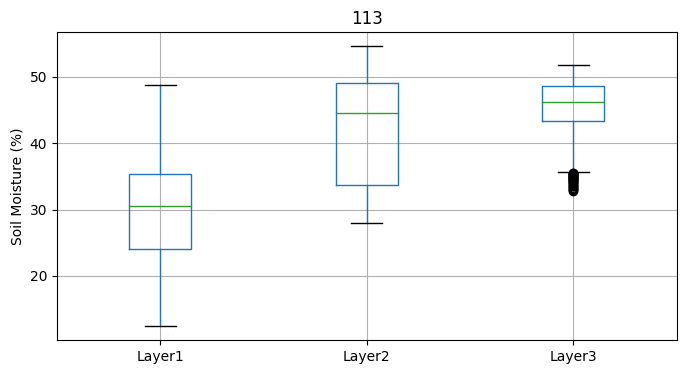




============== raw_data info for station 0114 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 166 out of 1891 
error rate: 8.78 %

Out of range values are :: 0 out of 1891 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1725.000000  1725.000000  1725.000000  1725.000000
mean     25.303884    42.630319    45.141507    43.834029
std       6.784009     5.556406     4.203468     4.075802
min      12.500000    24.700000    29.300000    30.900000
25%      19.600000    37.700000    41.600000    41.900000
50%      23.700000    44.900000    45.600000    43.900000
75%      31.500000    47.200000    48.700000    46.800000
max      41.600000    49.400000    51.000000    58.300000


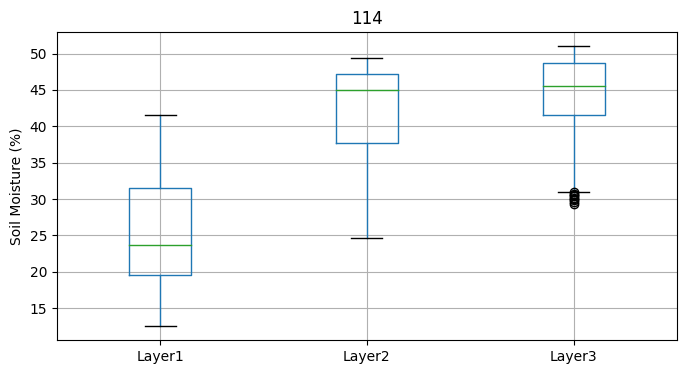




============== raw_data info for station 0115 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 10 out of 1884 
error rate: 0.53 %

Out of range values are :: 0 out of 1884 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1874.000000  1874.000000  1874.000000  1874.000000
mean     24.605496    39.267449    37.492369    31.657951
std       4.069211     4.928717     3.241473     2.478019
min      18.300000    28.100000    27.300000    23.700000
25%      20.900000    36.600000    36.325000    30.400000
50%      24.300000    41.300000    38.300000    31.800000
75%      27.675000    42.700000    39.600000    33.000000
max      43.400000    49.800000    46.000000    41.300000


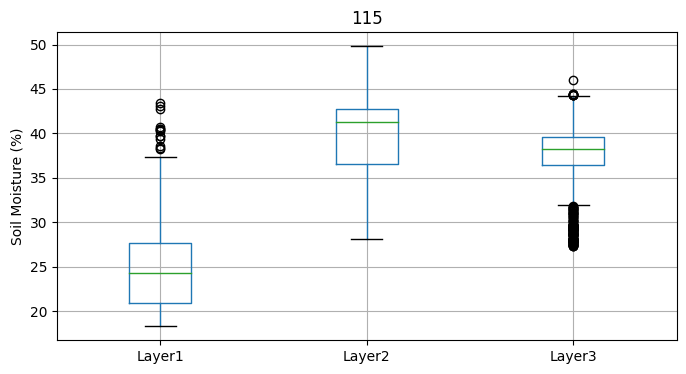




============== raw_data info for station 0116 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 59 out of 1838 
error rate: 3.21 %

Out of range values are :: 0 out of 1838 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1779.000000  1779.000000  1779.000000  1779.000000
mean     20.389601    30.831366    38.777965    47.287184
std       6.280884     7.726681     4.126338     1.811879
min       9.800000    15.600000    25.600000    41.900000
25%      15.600000    26.700000    37.000000    46.400000
50%      20.800000    33.600000    40.500000    47.200000
75%      25.600000    35.300000    41.000000    48.900000
max      47.500000    50.000000    52.000000    53.800000


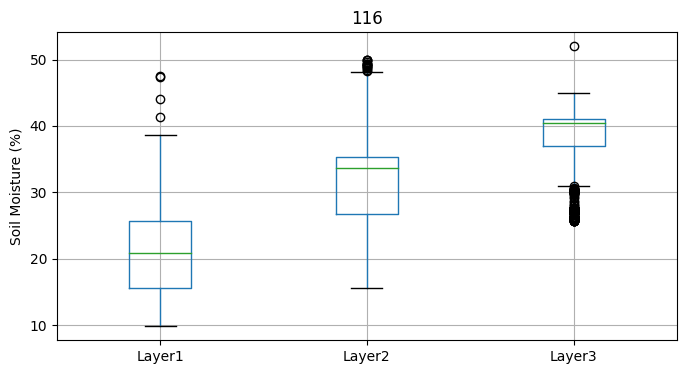




============== raw_data info for station 0118 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 3 out of 3 
error rate: 100.0 %

Out of range values are :: 0 out of 3 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

       Layer1  Layer2  Layer3  Layer4
count     0.0     0.0     0.0     0.0
mean      NaN     NaN     NaN     NaN
std       NaN     NaN     NaN     NaN
min       NaN     NaN     NaN     NaN
25%       NaN     NaN     NaN     NaN
50%       NaN     NaN     NaN     NaN
75%       NaN     NaN     NaN     NaN
max       NaN     NaN     NaN     NaN


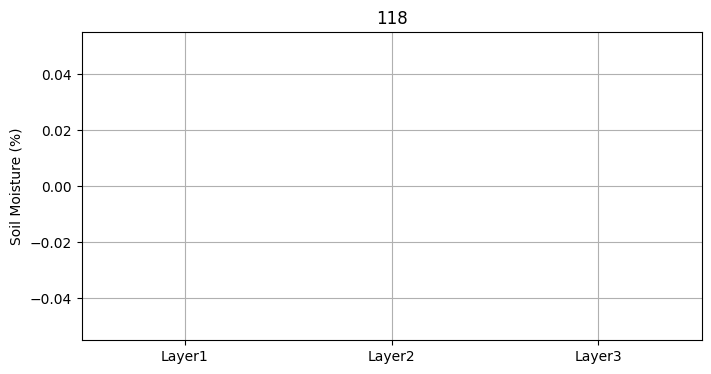




============== raw_data info for station 0554 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 53 out of 1662 
error rate: 3.19 %

Out of range values are :: 0 out of 1662 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1609.000000  1609.000000  1609.000000  1609.000000
mean     11.295152    22.575761    36.100746    40.727222
std       7.735854    11.556158     6.466831     3.209730
min       2.600000     5.000000    23.000000    30.100000
25%       5.900000    11.300000    31.800000    38.900000
50%       8.500000    23.100000    38.200000    41.900000
75%      15.200000    29.300000    40.600000    42.600000
max      45.500000    49.300000    48.000000    48.000000


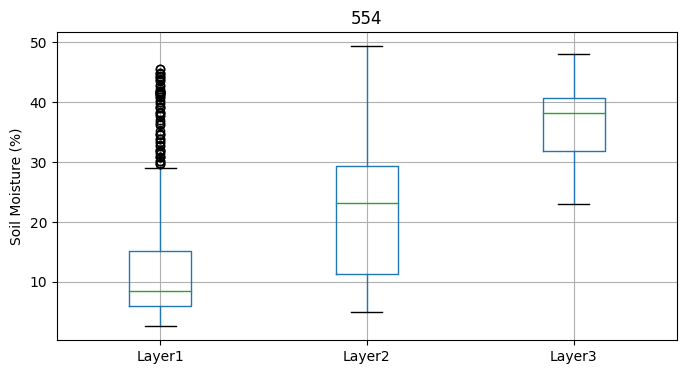




============== raw_data info for station 0555 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 248 out of 250 
error rate: 99.2 %

Out of range values are :: 2 out of 250 
error rate: 0.8 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

       Layer1  Layer2  Layer3  Layer4
count     0.0     0.0     0.0     0.0
mean      NaN     NaN     NaN     NaN
std       NaN     NaN     NaN     NaN
min       NaN     NaN     NaN     NaN
25%       NaN     NaN     NaN     NaN
50%       NaN     NaN     NaN     NaN
75%       NaN     NaN     NaN     NaN
max       NaN     NaN     NaN     NaN


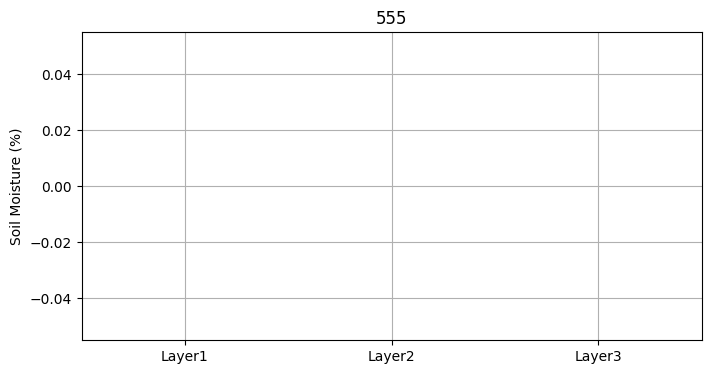




============== raw_data info for station 0556 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 181 out of 4935 
error rate: 3.67 %

Out of range values are :: 0 out of 4935 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  4754.000000  4754.000000  4754.000000  4754.000000
mean     19.809466    27.149180    28.215355    35.990324
std       7.374407     4.890382     8.252427     7.492930
min       5.200000    19.400000    16.200000    21.400000
25%      14.800000    23.000000    21.600000    29.100000
50%      19.700000    26.200000    29.500000    37.800000
75%      24.100000    30.100000    32.600000    40.800000
max      45.900000    46.900000    51.300000    49.600000


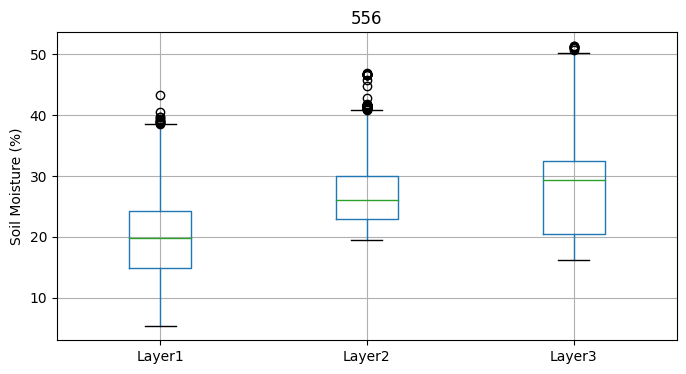




============== raw_data info for station 0557 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 80 out of 1738 
error rate: 4.6 %

Out of range values are :: 0 out of 1738 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1658.000000  1658.000000  1658.000000  1658.000000
mean     31.138179    41.653136    43.737153    45.448432
std       8.796401     5.148068     5.270561     4.571229
min      12.200000    34.200000    32.300000    26.300000
25%      26.600000    36.900000    38.100000    44.200000
50%      30.600000    39.600000    45.500000    45.800000
75%      36.800000    46.800000    49.000000    48.300000
max      61.000000    53.500000    58.300000    63.400000


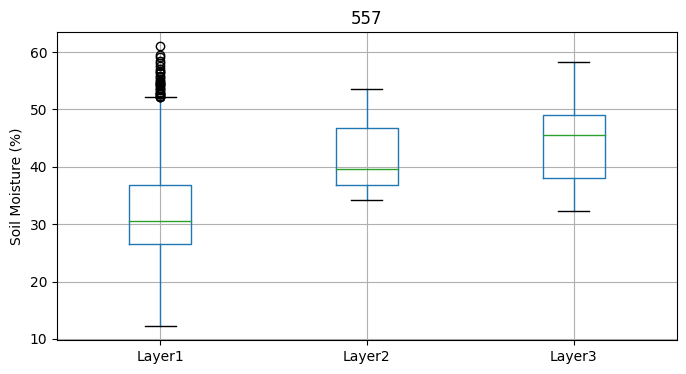




============== raw_data info for station 0558 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 52 out of 1690 
error rate: 3.08 %

Out of range values are :: 0 out of 1690 
error rate: 0.0 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1638.000000  1638.000000  1638.000000  1638.000000
mean     19.943162    30.176679    27.495665    29.987851
std       5.372885     8.665300     5.734604     4.261740
min      12.900000    15.800000    17.500000    21.600000
25%      15.625000    20.500000    22.925000    28.300000
50%      18.600000    33.400000    29.700000    29.750000
75%      23.400000    37.700000    31.700000    30.500000
max      43.300000    46.400000    45.900000    50.000000


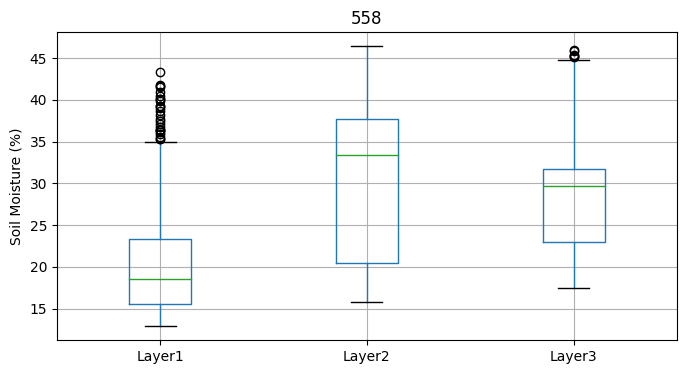




============== raw_data info for station 0629 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 87 out of 1691 
error rate: 5.14 %

Out of range values are :: 2 out of 1691 
error rate: 0.12 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1       Layer2       Layer3       Layer4
count  1602.000000  1602.000000  1602.000000  1602.000000
mean     21.392634    27.027591    43.079526    54.692447
std       6.678239     5.889206     5.666415     3.325686
min      14.200000    20.800000    34.500000    43.600000
25%      15.700000    22.300000    37.200000    51.700000
50%      18.400000    25.700000    43.300000    56.750000
75%      25.100000    30.200000    46.700000    57.400000
max      49.400000    50.200000    56.000000    58.200000


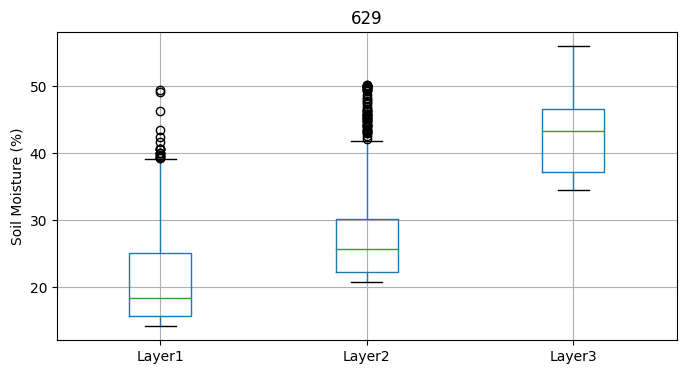




============== raw_data info for station 0630 ==============
::::::::::::::::::::: NaN values info ::::::::::::::::::::::
NaN values are :: 81 out of 1686 
error rate: 4.8 %

Out of range values are :: 80 out of 1686 
error rate: 4.74 %

:::::::::::::::::::::: Data Describe :::::::::::::::::::::::

Layer1    float64
Layer2    float64
Layer3    float64
Layer4    float64
dtype: object

            Layer1      Layer2       Layer3       Layer4
count  1525.000000  1525.00000  1525.000000  1525.000000
mean     20.680787    16.09659    33.784131    37.357377
std       9.138249    10.65104    10.525103     8.124032
min       9.800000     2.70000    16.500000    21.200000
25%      12.300000     5.40000    21.800000    32.600000
50%      16.400000    14.40000    40.500000    41.900000
75%      28.900000    26.70000    42.400000    43.300000
max      41.600000    38.10000    48.100000    50.500000


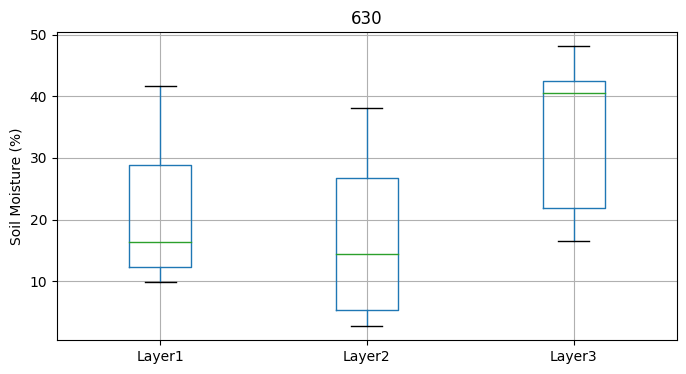

Station List :: ['0111', '0112', '0113', '0114', '0115', '0116', '0118', '0554', '0555', '0556', '0557', '0558', '0629', '0630']



=======================0111 :: Layer2=======================
:::::::::::::::::0111 :: Layer2  Rainfinder:::::::::::::::::
0111 | LEN = 812
Searched  5 days with bump events
[[2024, 5, 26], [2024, 5, 27], [2024, 6, 5], [2024, 6, 14], [2024, 6, 29]]
Field Capacity is found for 2024-5-26 : 2024-05-30 25.096
Graph is saved.
Field Capacity is found for 2024-5-27 : 2024-05-30 25.096
Graph is saved.
Field Capacity is found for 2024-6-5 : 2024-06-18 27.837
Graph is saved.
Field Capacity is found for 2024-6-14 : 2024-06-18 27.837
Graph is saved.



=======================0112 :: Layer2=======================
:::::::::::::::::0112 :: Layer2  Rainfinder:::::::::::::::::
0112 | LEN = 2701
Searched  2 days with bump events
[[2024, 5, 21], [2024, 5, 26]]
Field Capacity is found for 2024-5-21 : 2024-05-26 29.1
Graph is saved.
Field Capacity is found for 2024-5-26 : 2024-

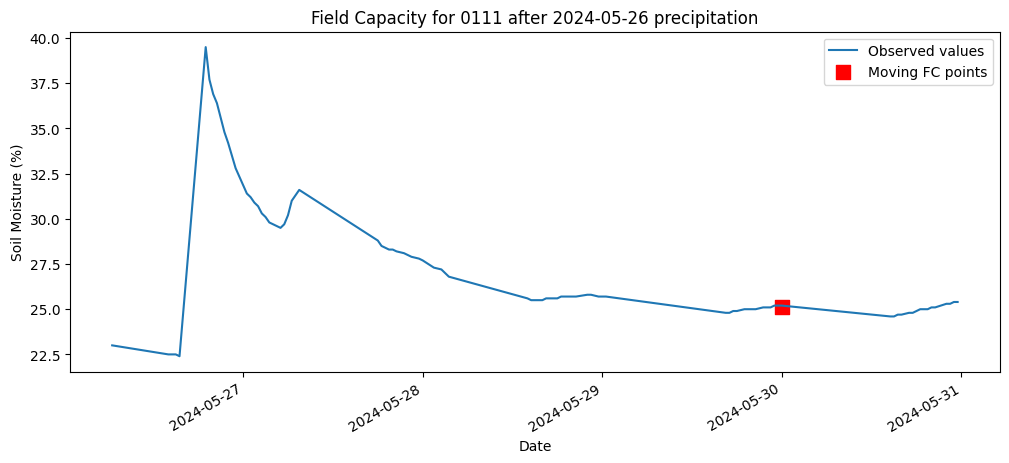

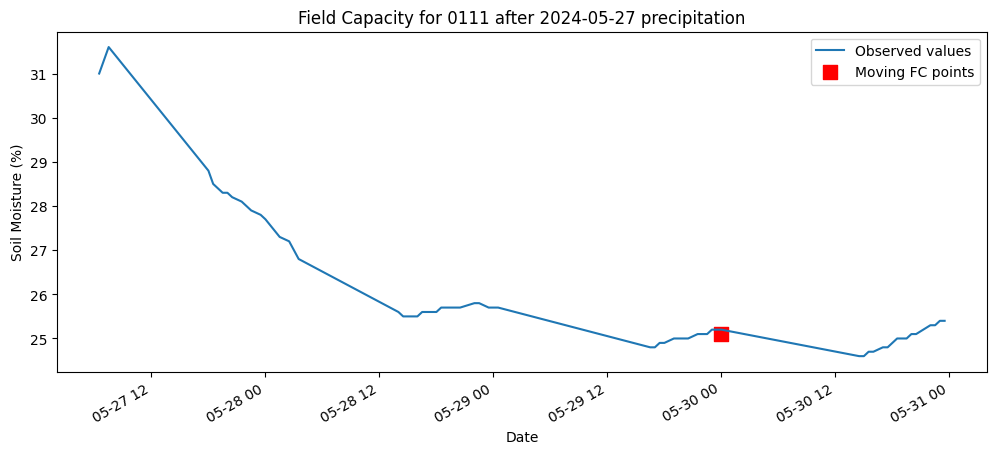

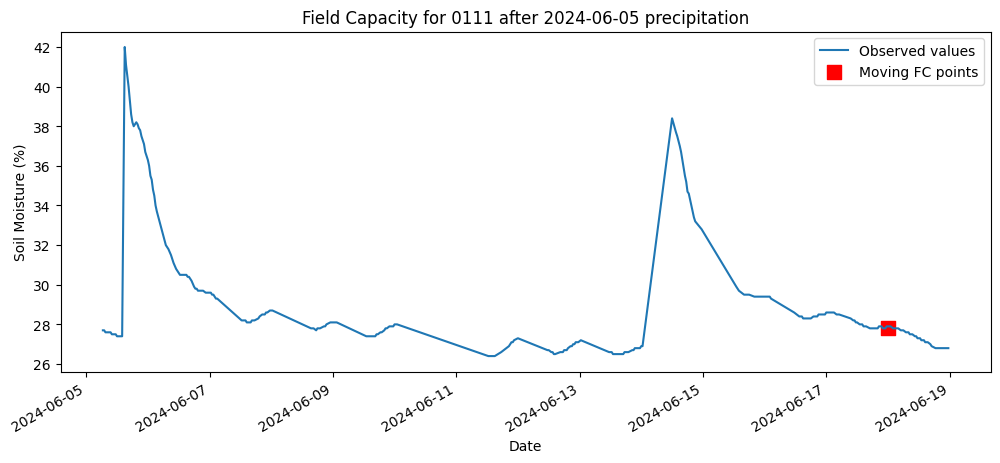

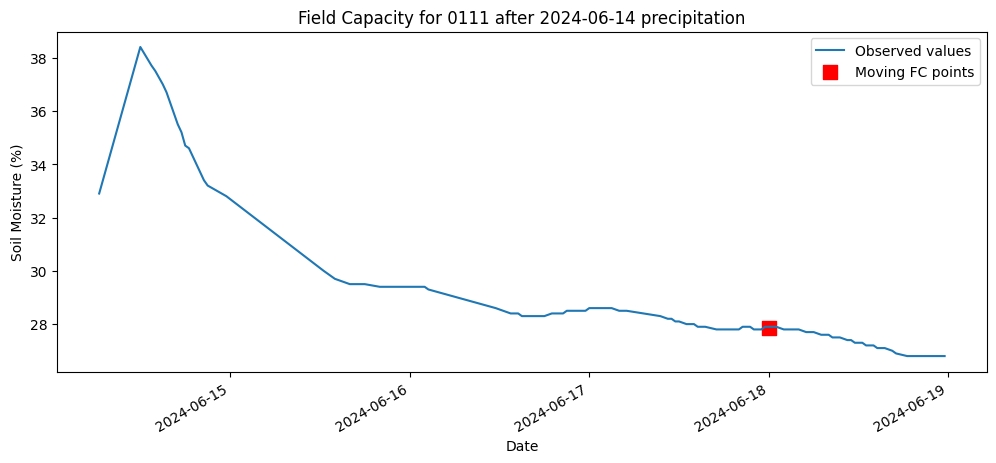

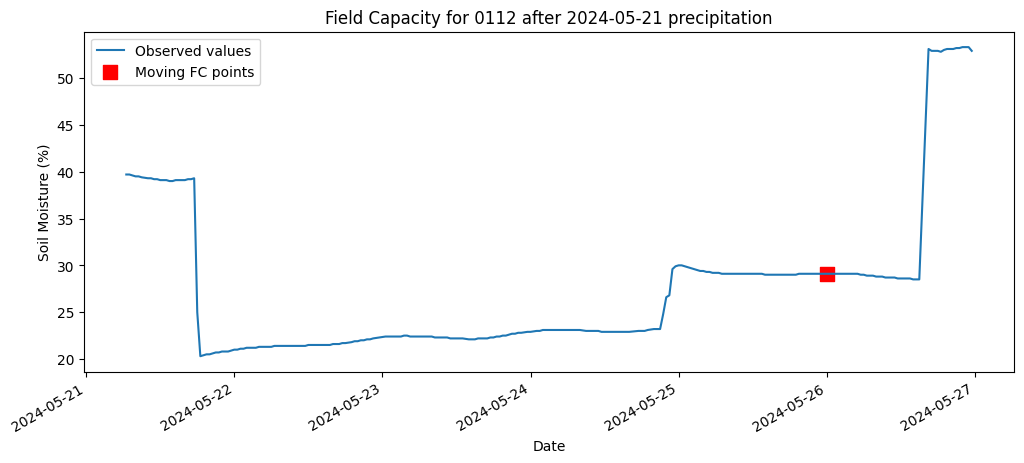

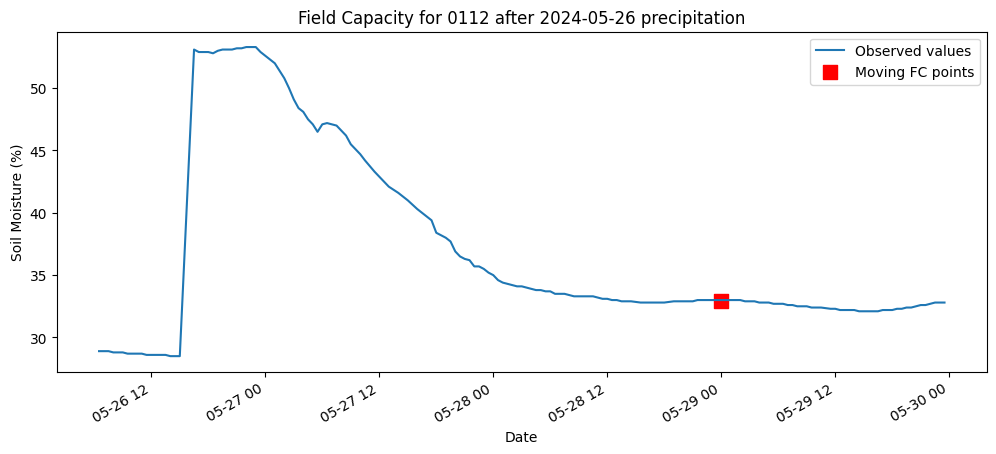

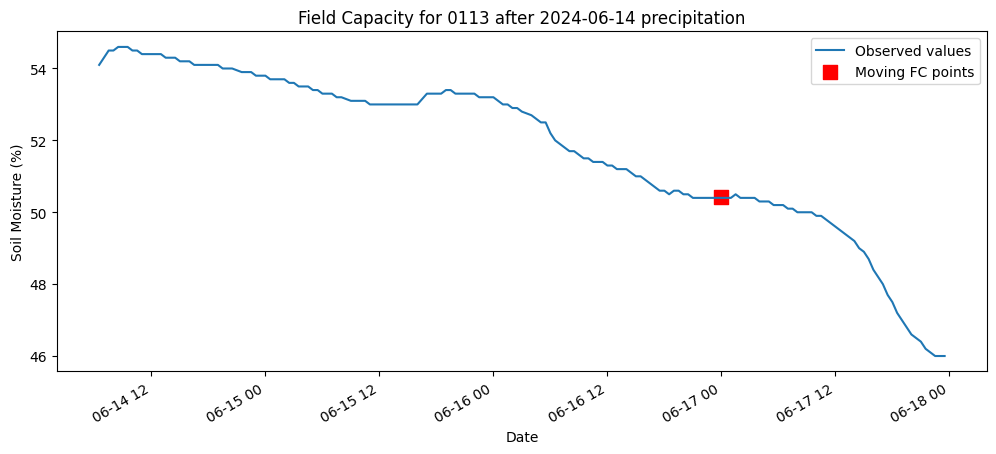

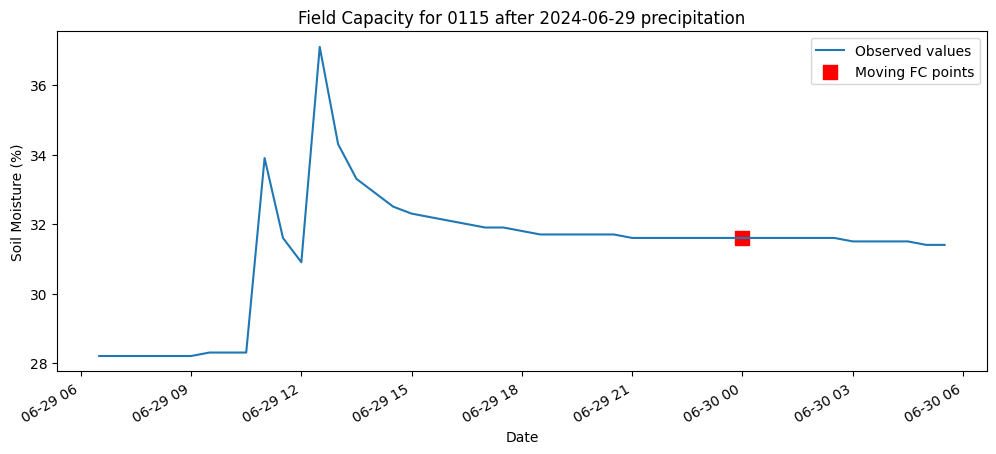

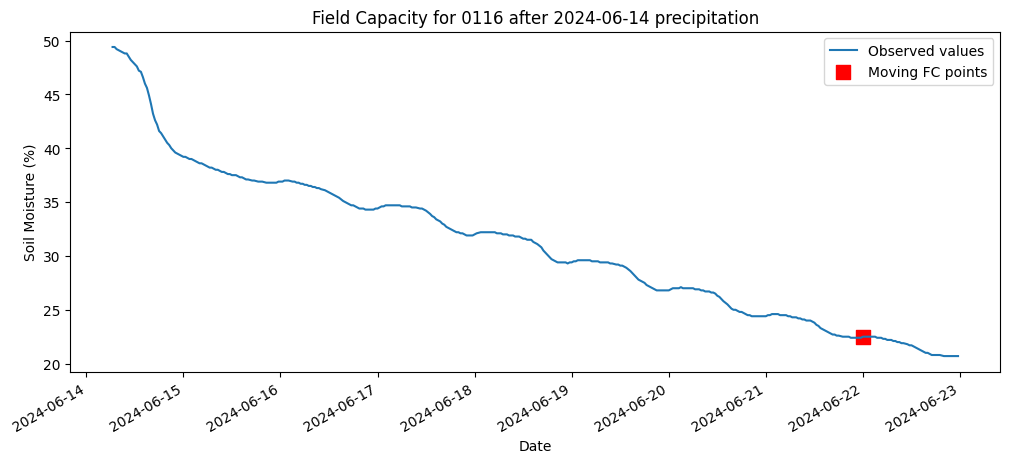

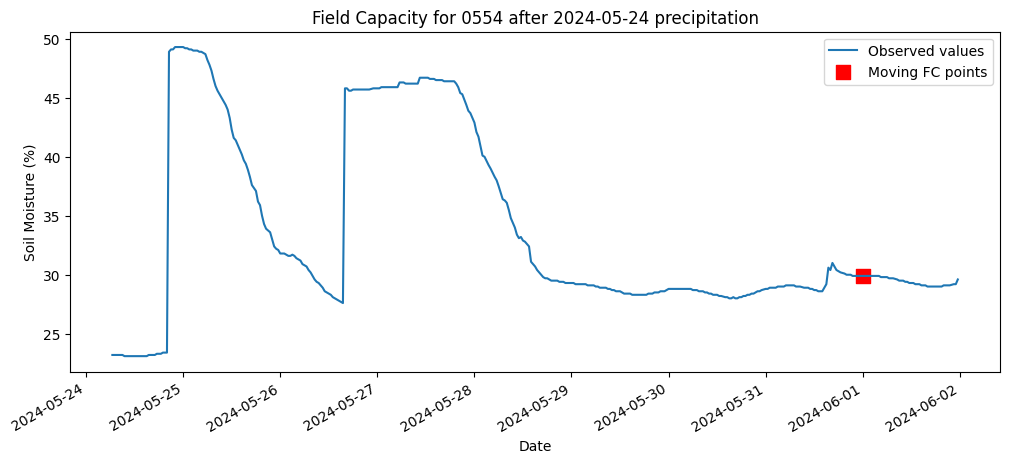

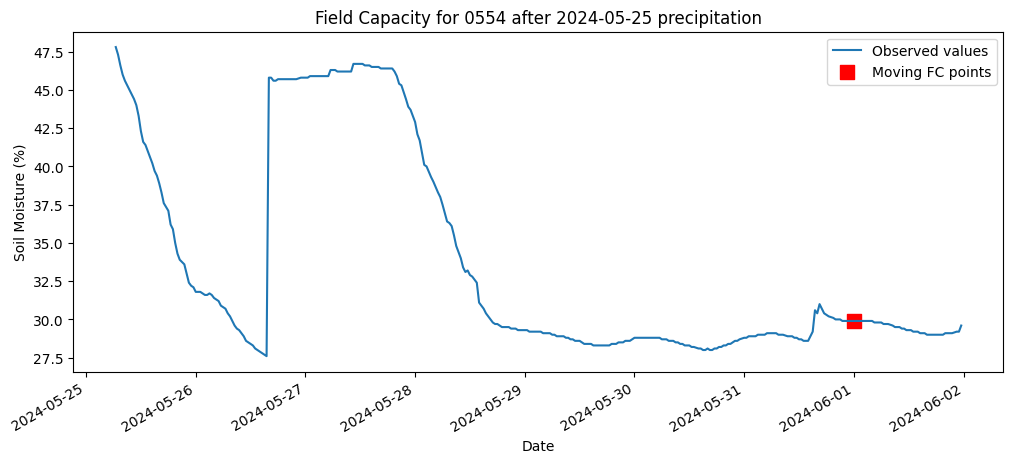

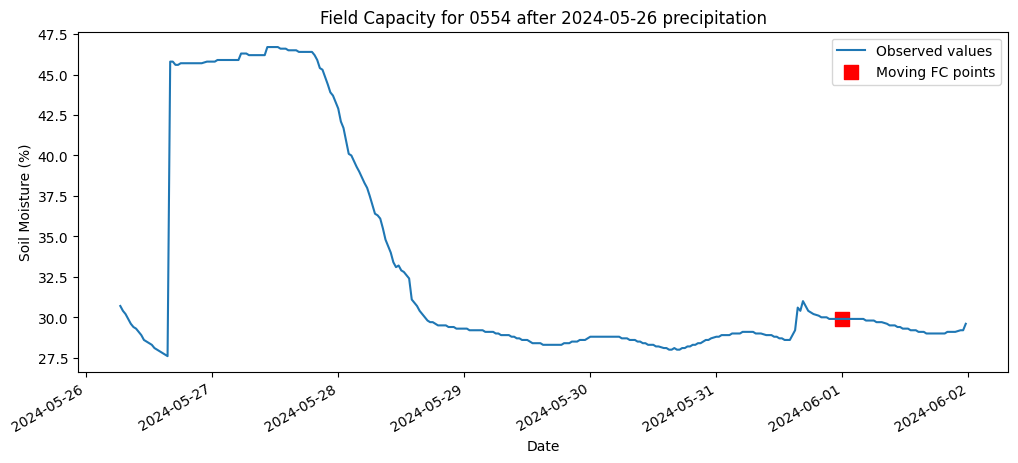

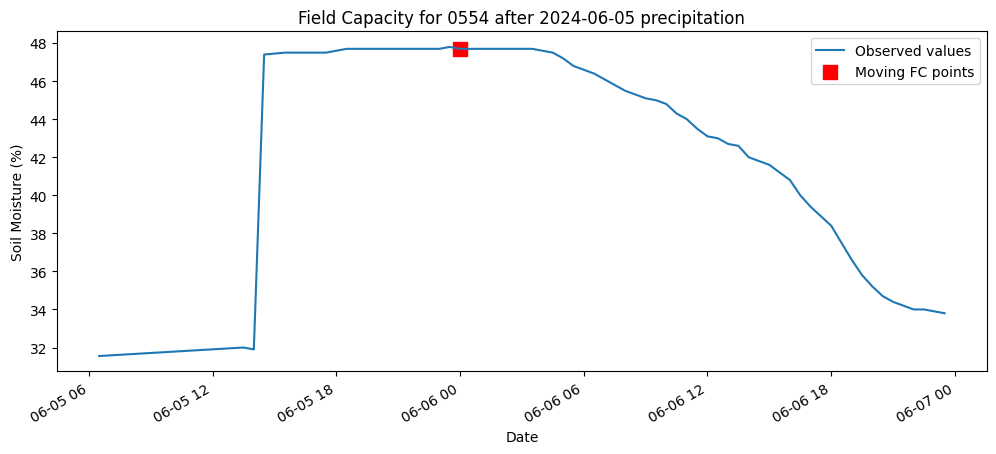

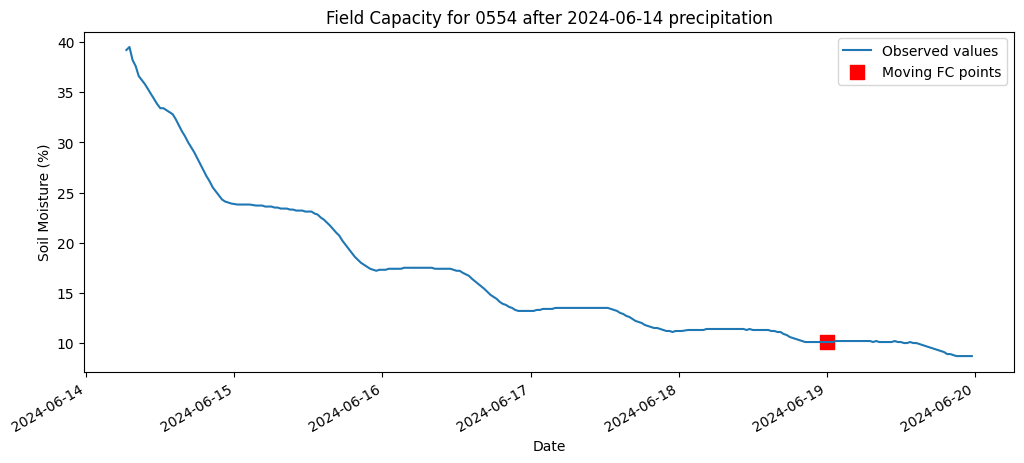

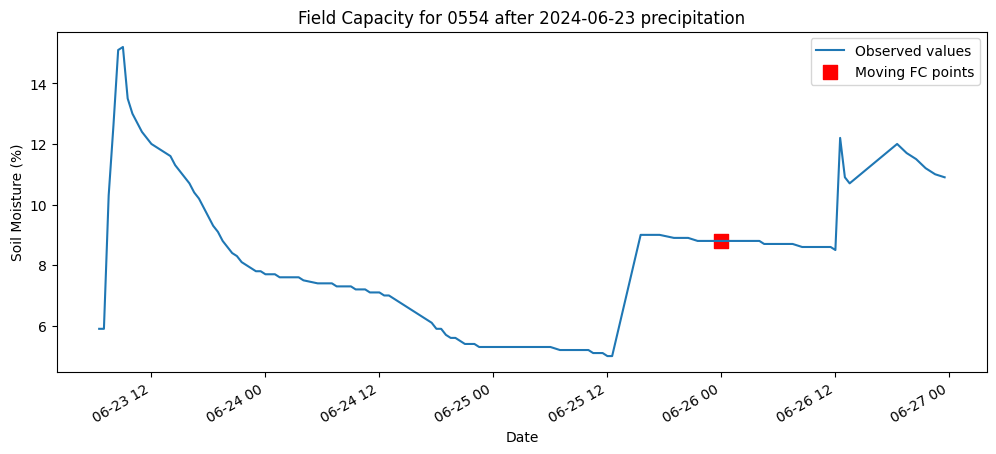

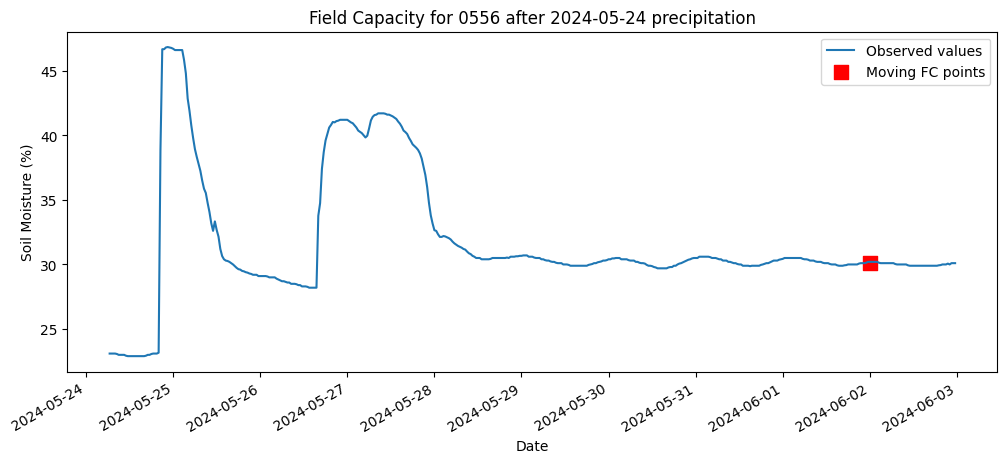

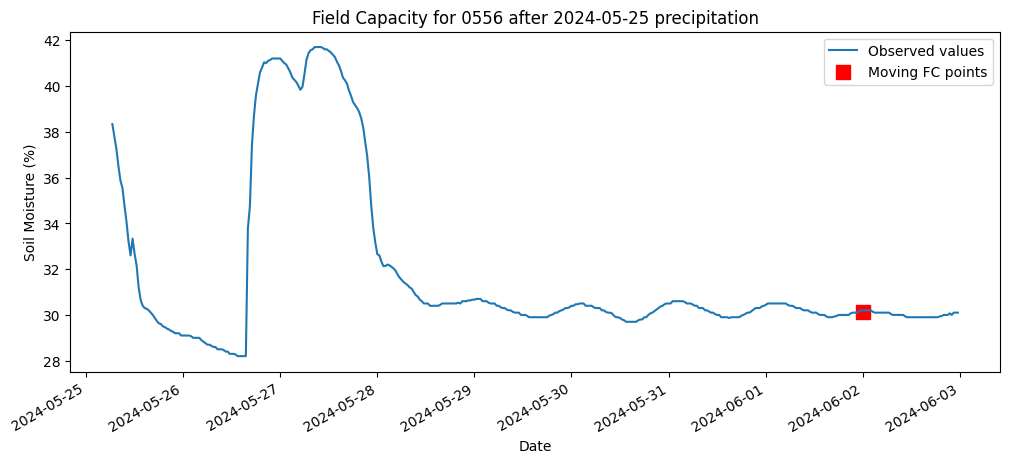

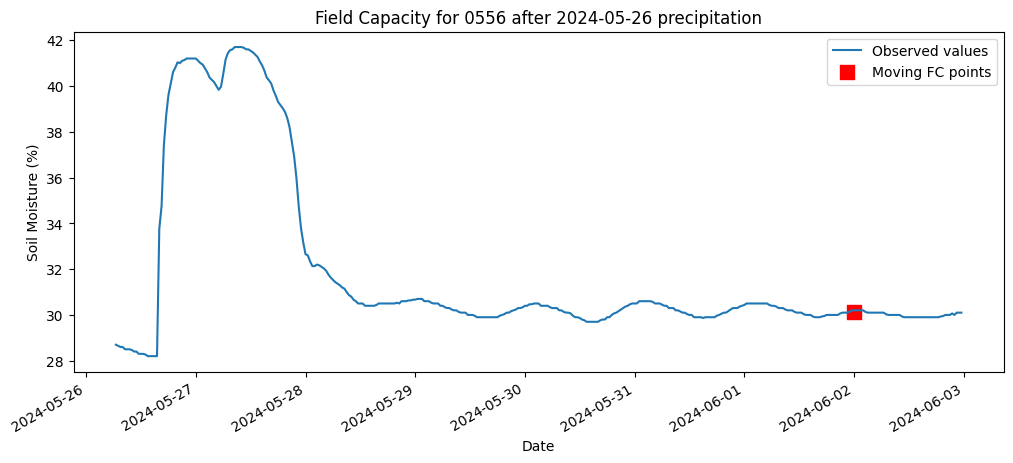

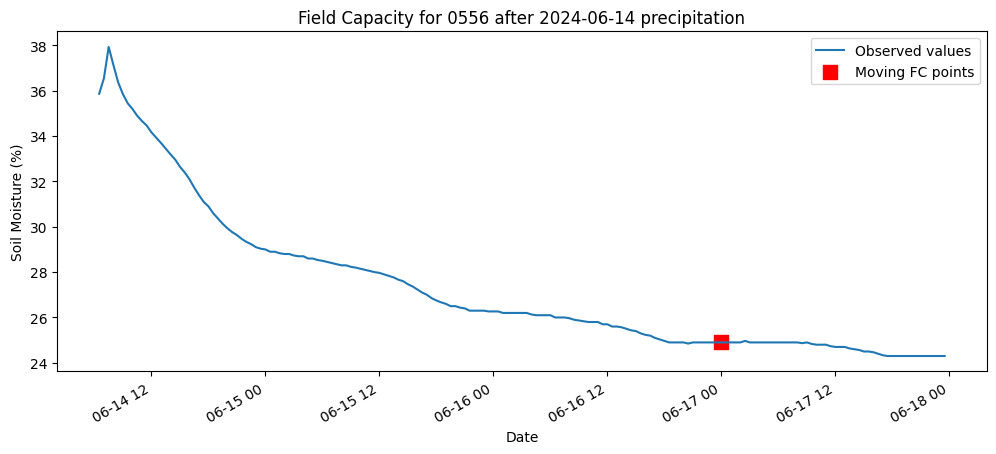

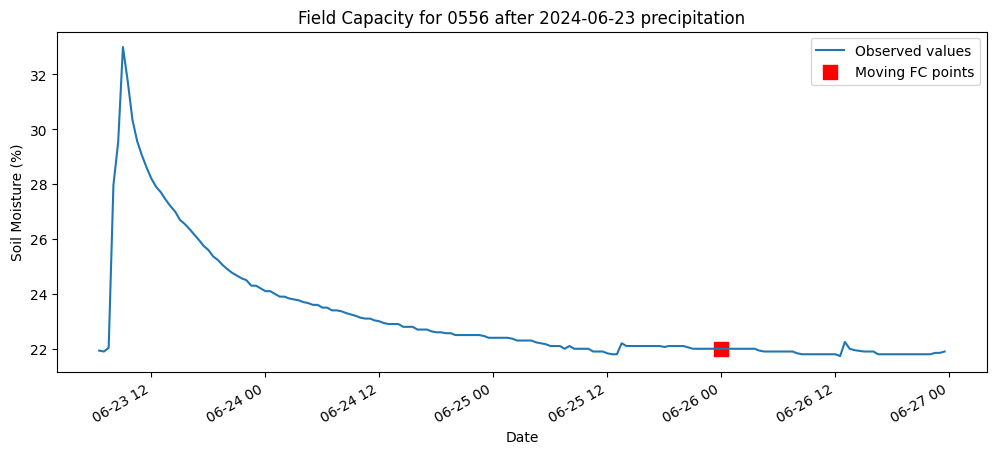

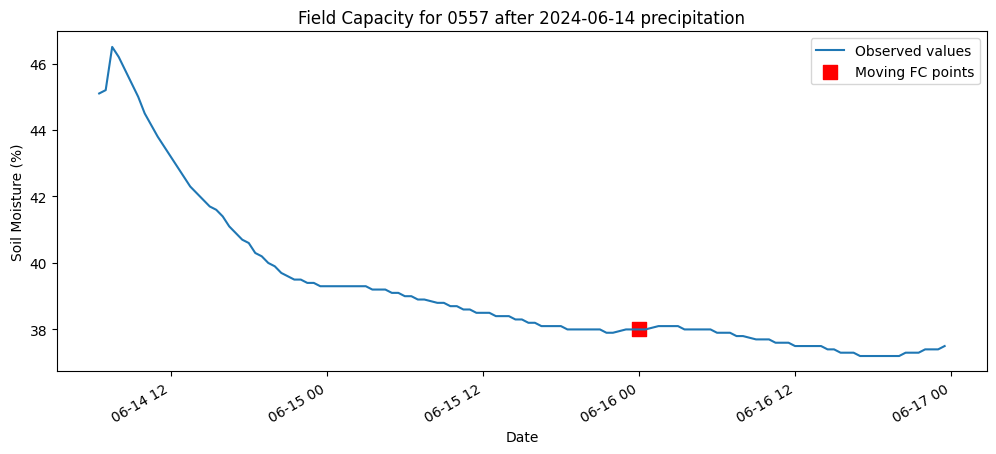

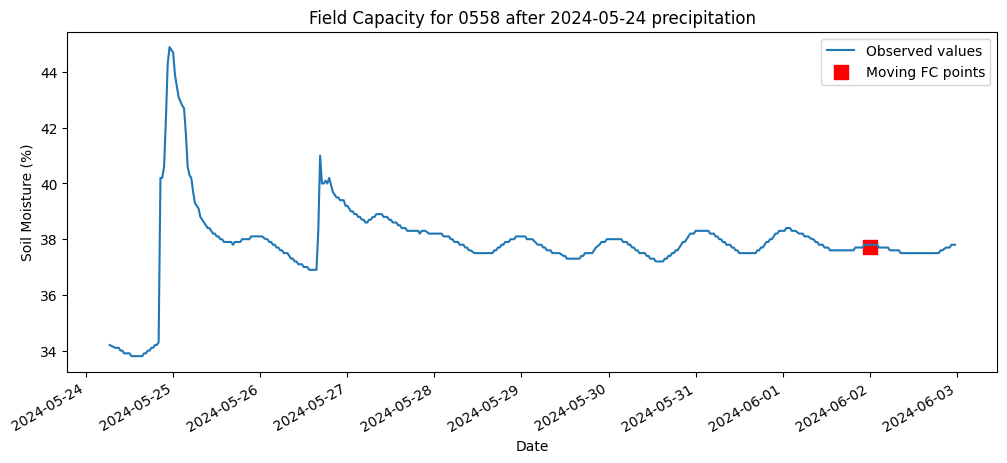

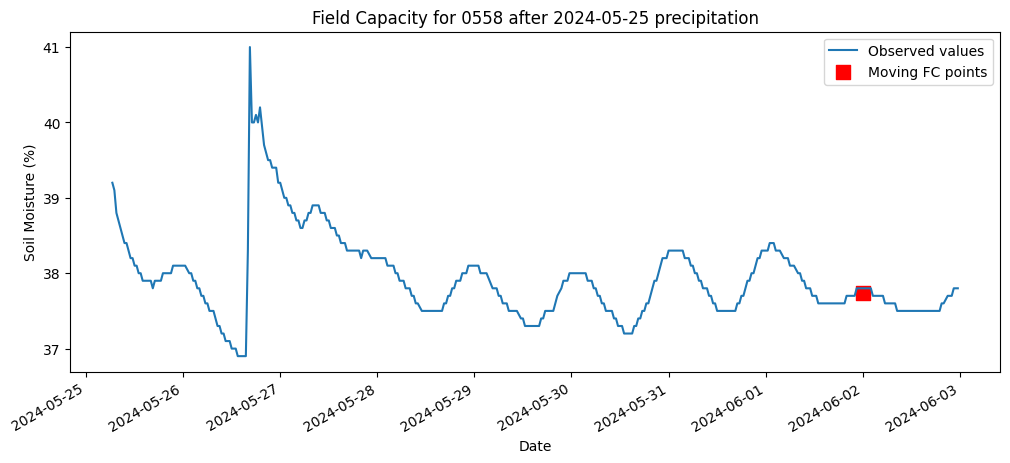

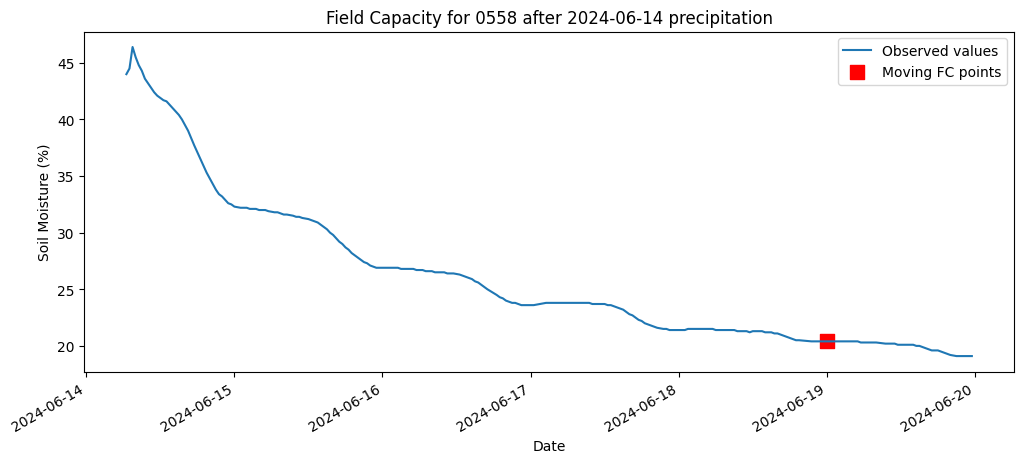

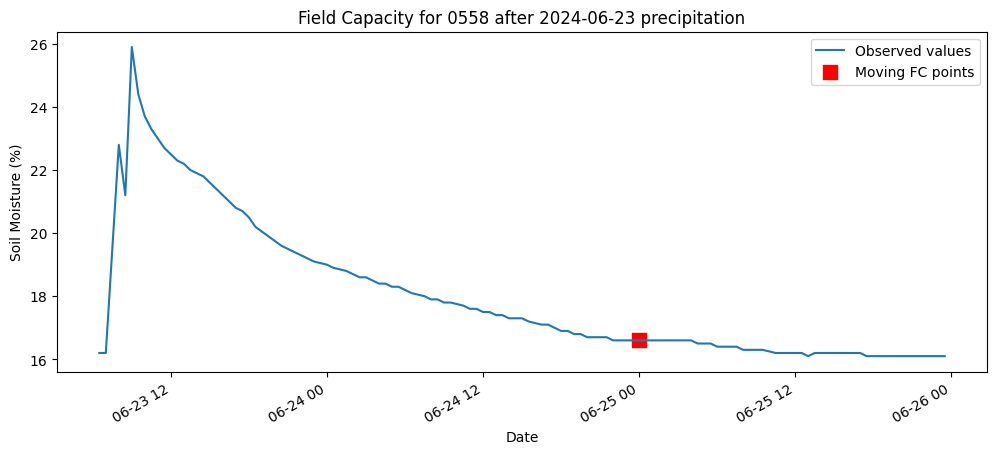

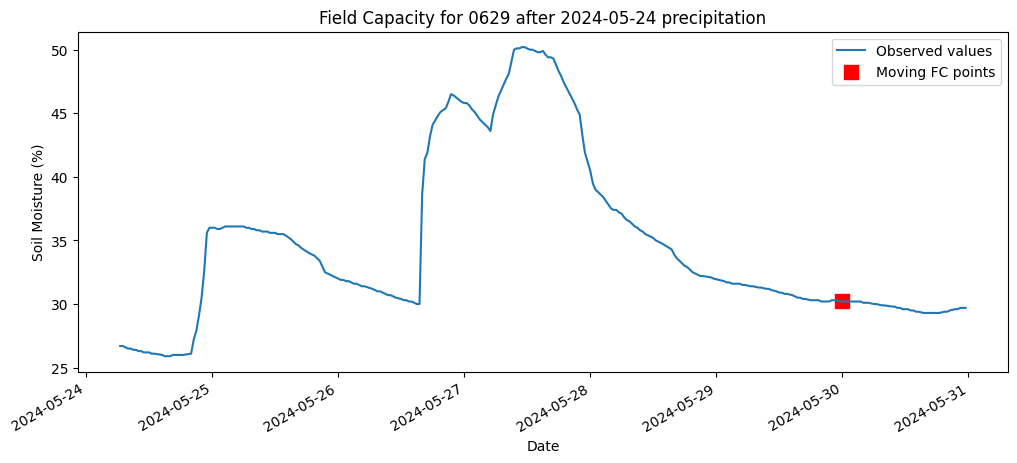

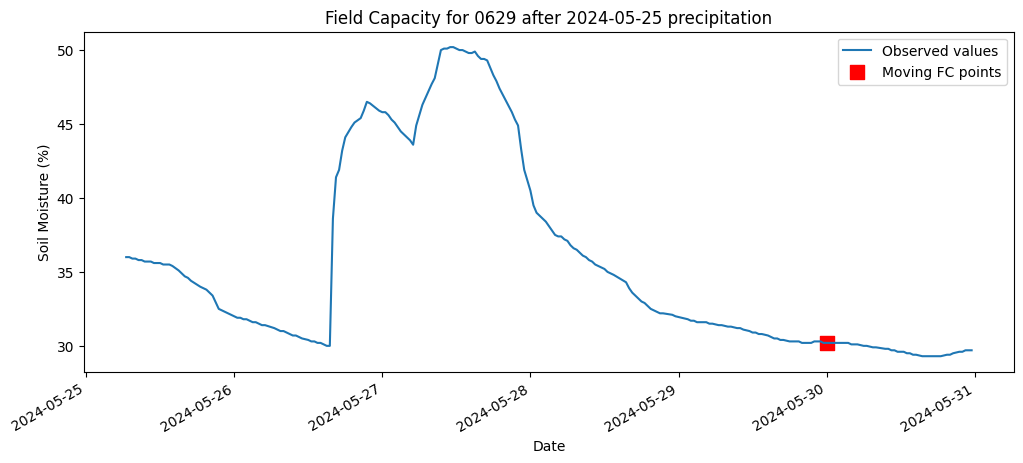

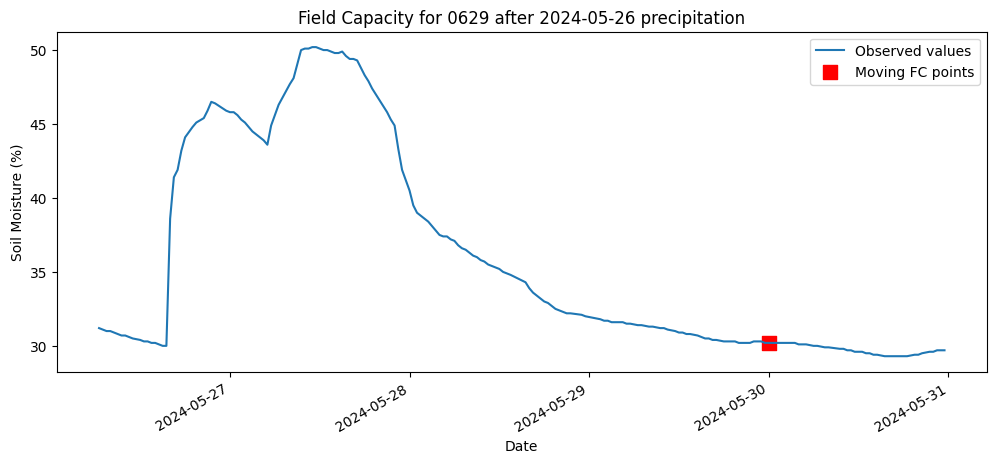

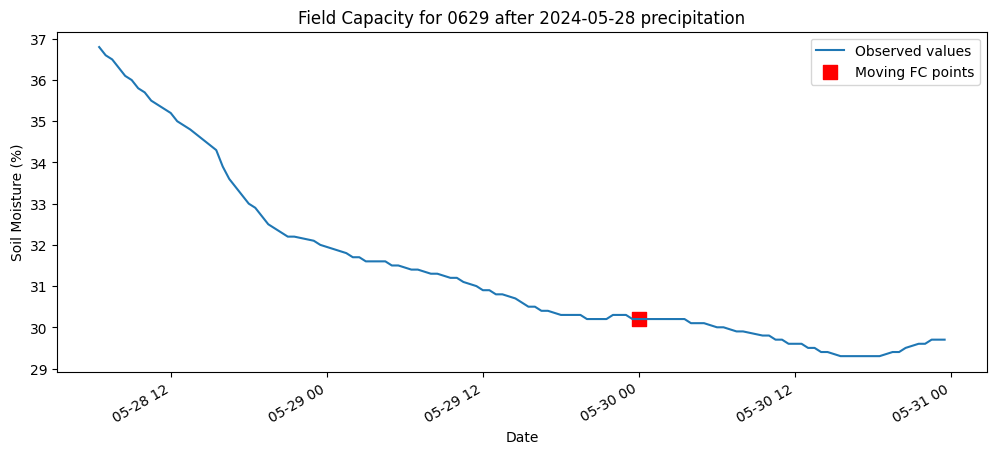

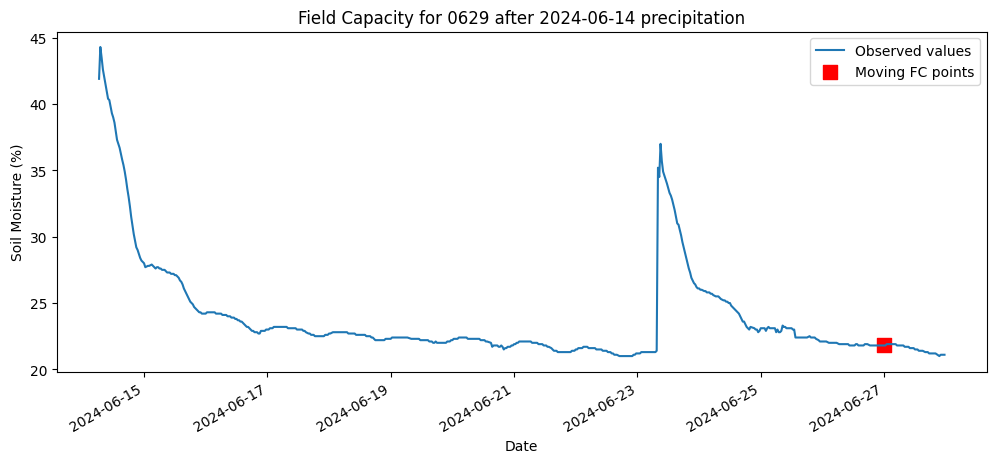

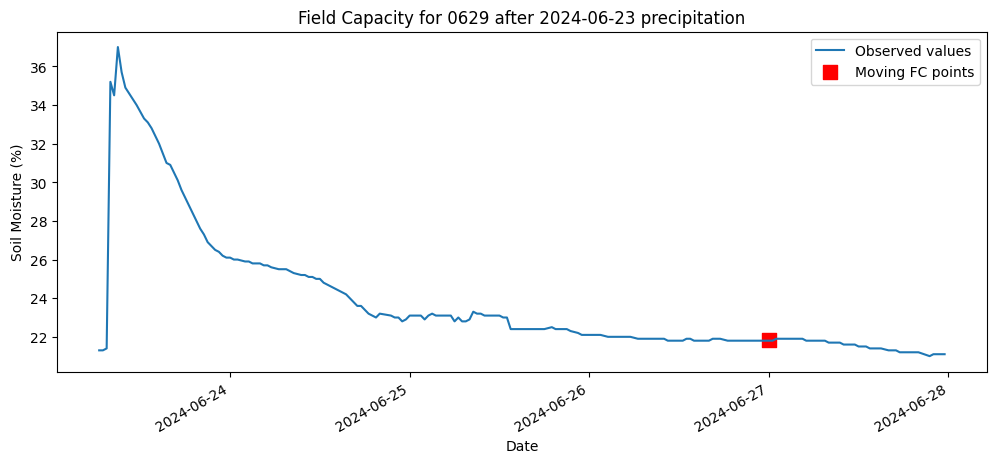

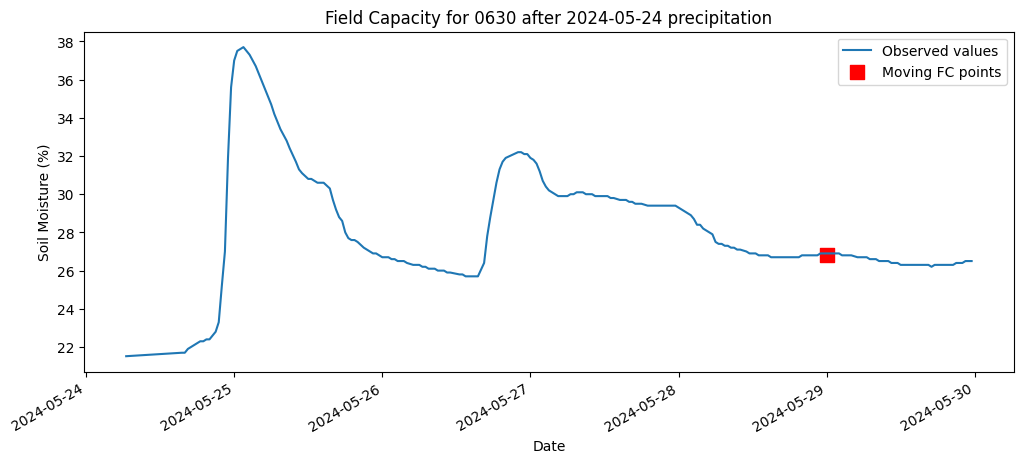

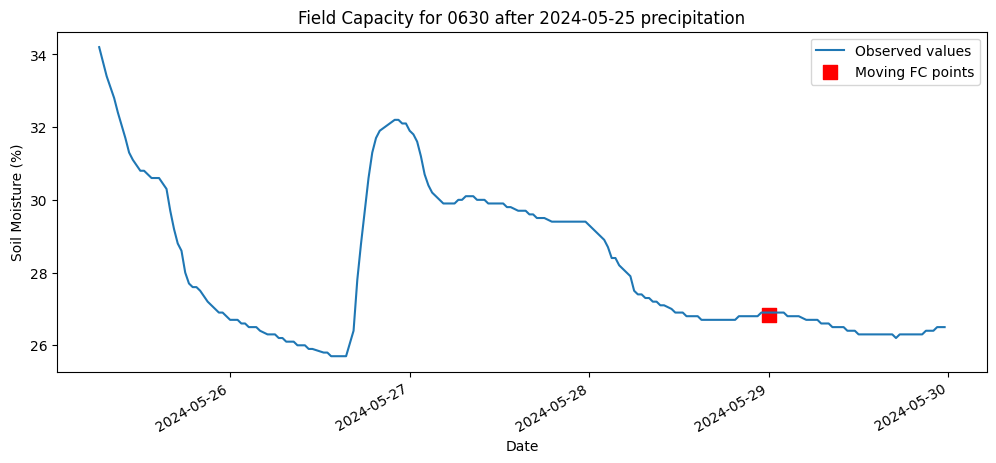

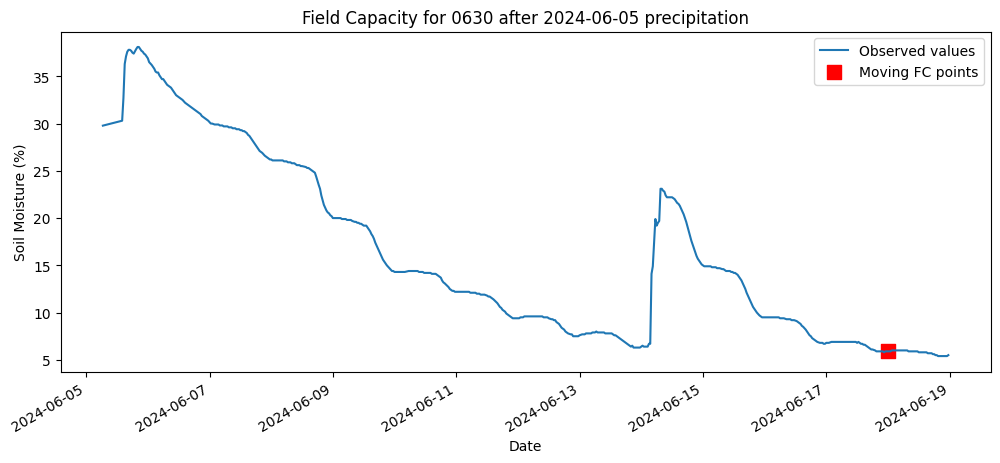

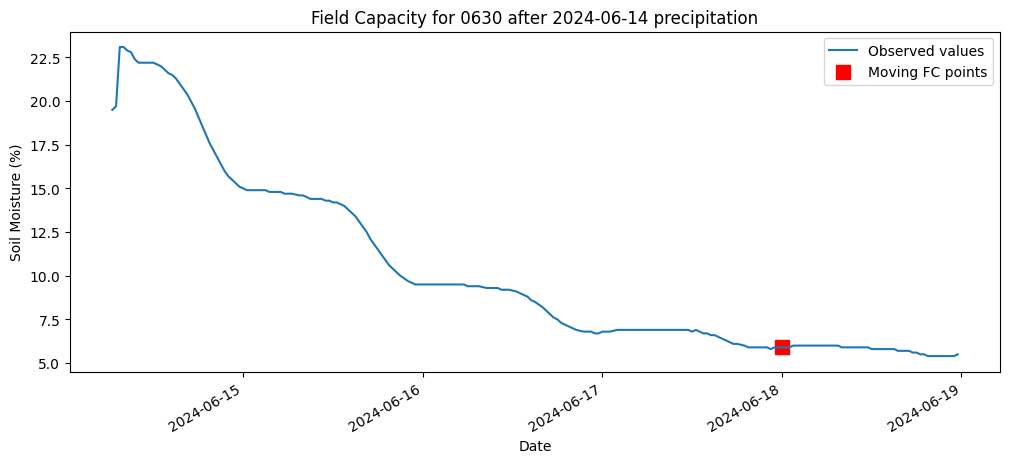

In [9]:
import warnings
warnings.filterwarnings('ignore')

'''
Implementation Block

set up the variables for running the programs
you will set the destination of the files (directory)
you will set the date of your interest.
usually, it is set to today's date

'''

destination = os.getcwd()+'/'
today_dt = datetime.datetime.now()
today_dt = datetime.datetime(today_dt.year, today_dt.month, today_dt.day, 6, 00)
filename = destination + '01_Raw_data/data-'+today_dt.strftime('%Y-%m-%d-%H-%M')+'.csv'
# TODO testing
# filename = destination + '01_Raw_data/Calc_def_test.csv'    # should be ';' delimeter for the sample files
# filename = destination + '01_Raw_data/Calc_def_test_0725.csv'
# ! filename should be changed to file name of the downloaded data
foutname = './02_Clean_data/SM_data'+strtoday+'.csv'

# set the time of interest and location [year, month, day]
#  this is for the data of soil moisture. = for the date of the analysis
# for regular 
ed_date = [dt.date.today().year, dt.date.today().month, dt.date.today().day]
# end date will be 
st_datetime = dt.datetime(ed_date[0], ed_date[1], ed_date[2], 6, 0, 0) - dt.timedelta(days=360)
st_date = [st_datetime.year, st_datetime.month, st_datetime.day]

raw_data, raw_columns, clean_df, stationlist, raw_columns = readraw_data(destination, filename, foutname, st_date, ed_date)



''' 
This is the main part of the program
below section will estimate the field capacity for the given data [Daily basis]

This part should be done per station [stationlist]
'''
# for testing
# stationlist = ['0111','0112','0114']
print ('Station List ::',stationlist)

# this is the target layer for the analysis. 1=layer 1
# variable set for rainfinder
# *-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= CHECK THE PARAMETERS =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-* #
target = 'Layer2'
threshold_moist = 8    # threshold of soil moisture difference to decide it was huge rain event or not default: 15
raintimestep = 12 # 1 = 1/2 hour // 12 = 6 hours

# variable set for FCfinder
search_days = 14 # days
search_range = 5 # hours
search_slope = 0.07 # unit is fraction for standard deviation of the soil moisture behavior
threshold_hour = 4 # hours with consistent soil moisture behavior
# *-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= CHECK THE PARAMETERS =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-* #


f=open(os.getcwd()+'/04_fc_results/'+strtoday+'_fc_record.csv', 'w')   # making a file to save the daily field capacity
f.write('Station,Date,Layer1,Layer2,Layer3,Layer4\n')
f.close()
for station in stationlist:
    print('\n\n')
    text = station +' :: '+target
    print (text.center(60,'='))
    bumplist = rainfinder(clean_df, station, raw_columns, threshold_moist, raintimestep)
    for start_date in bumplist:
        FCfinder(clean_df, station, raw_columns, start_date, search_days, search_range, search_slope, threshold_hour)


update_fc() # update the field capacity data
print ('Field Capacity Update is Done.\n\n\n')


'''
this part will calculate the soil defecit based on the field capacity data exported from update_fc function
'''
deficit_calc()

print ('*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')
print ('Deficit Calculation is Done.\n')
print ("Check the ./04_fc_results/"+strtoday+"_fc_record.csv folder for the today's field capacity data.")
print ("Check the ./05_fc_graphs/ folder for the today's field capacity graph")
print ("Check the ./00_Current_FieldCapacity.csv file for the most updated field capacity data.")

# Run additional Functions
deficit_df = org_deficit()